# Проект "Аналитика данных компании Gectaro"

**Описание:**

Gectaro – облачный сервис для автоматизации управления строительством и ремонтом.

Компания продает софт с платной подпиской в сегменте B2B (наиболее частый срок подписки 12-24 месяца), предназначенный для управления процессами в сфере строительства и ремонта.

Основная проблема – это уход из сервиса большого количества подписчиков и не продление подписки.

**Цели исследования:**

- проанализировать имеющиеся данные; 
- составить портреты наиболее типичных клиентов; 
- определить ключевые признаки для компаний, наличие которых влияет на отмену  подписки; 
- разобраться в причинах оттока клиентов; 
- предложить решения по их минимизации. 


**Задачи:**

- провести исследовательский анализ данных;
- сформулировать и проверить гипотезы, основываясь на имеющихся признаках;
- формулирование выводов по полученным результатам, подготовка презентации.




**Ход исследовия:**
- прочитать данные из файла и сохранить в датафремы;
- обзор и преобработка входных данных;
- исследовательский анализ данных;
- проверка гипотез и поиск признаков оттока;
- формулирование выводов по полученным результатам;
- подготовка презентации.ации.

## Описание данных

**Файл активностей** `activities.csv`:

- `Company_id` - идентификатор компании;
- `Month` - отчетный месяц;
- `Company-month-billing` - количество счетов, выставленных в приложении, компанией за месяц;
- `Company-month-stocks` - месячное количество складов (аренда, заказы и т.д.), используемых компанией;
- `Company-month-backups` - месячное количество бэкапов компании;
- `Company-month-projects` - месячное количество проектов компании;
- `Company-month-contractors` - месячное количество контрагентов компании;
- `Company-month-resource_orders` - месячное количество заказов материалов компании.
 
**Файл платежей** `billing.csv`:
- `Unnamed:0` - индекс;
- `User_id` - идентификатор пользователя;
- `Company_id` - идентификатор компании пользователя;
- `Billing_tariff_id` - тарифный план;
- `Payed_until` - дата, до которой подписка компании действует;
- `Is_payed` - статус оплаты;
- `Created_at` - дата создания;
- `Updated_at` - дата обновления;
- `Billing_tariff_price_id` - id стоимости тарифа;
- `Comment` - комментарии;
- `Pay_date` - дата платежа.
 
**Файл компаний** `companies.csv`:
- `Id` - id компании; 
- `Working_direction` - сфера деятельности;
- `Employer_count_interval` - id количества сотрудников;
- `Created_at` - дата создания компании в системе;
- `Updated_at` - дата обновления информации о компании;
- `Billing_tariff_id` - id тарифа;
- `Billing_is_over` - истекла ли оплата.
 
**Файл сотрудников** `people.csv`:
- `Id` - индекс; 
- `Company_id` - id компании; 
- `User_id` - id пользователя; 
- `Role_id` - id роли (должности); 
- `Created_at` - дата создания пользователя; 
- `Updated_at` - дата обновления информации о пользователе; 
- `Is_deleted` - удален ли пользователь; 
- `Deleted_at` - дата удаления.
 

## Настройка рабочей среды

In [1]:
# Подгрузка модулей
import math
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from matplotlib import gridspec
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency


## Глобальные переменные

In [2]:
start_date = datetime.strptime('2024-03-28', '%Y-%m-%d')

# Уровень статистической значимости
alpha = 0.05

# момент анализа
observation_date = start_date.date()
# горизонт анализа
horizon_months = 12   

dictionary = {
    'billing_is_over' : {
        True: 'оплата истекла', 
        False: 'оптала не истекла'
    },
    'billing_tariff_id' : {
        1 : '1 - тестовый',
        2 : '2 - базовый',
        3 : '3 - профи',
        4 : '4 - старт',
        6 : '6 - архивный',
        7 : '7 - старт',
        8 : '8 - старт',
        9 : '9 - бизнес',
        10 : '10 - профи',
        11 : '11 - старт',
        13 : '13 - профи',
        17 : '17 - базовый',
        18 : '18 - бесплатный',
        19 : '19 - старт',
        20 : '20 - бизнес',
        21 : '21 - профи',
        22 : '22 -пробный',
    },
    'billing_tariff_type' : {
        0 : 'архивный',
        1 : 'старт',
        2 : 'базовый',
        3 : 'бизнес',
        4 : 'профи',
    },
    'company_is_active' : {
        True: 'активные', 
        False: 'неактивные'
    },
    'is_active' : {
        True: 'активные', 
        False: 'неактивные'
    },
    'employer_count_interval' : {
        1: '1 - 4 чел.', 
        2: '5 - 10 чел.',
        3: '11 - 20 чел.', 
        4: '21 - 30 чел.',
        5: '31 - 50 чел.', 
        6: '51 - 100 чел.',
        7: '101 - 200 чел.', 
        8: '> 201 чел.',
    },
    'is_deleted' : {
        True: 'удаленные', 
        False: 'действующие'
    },
}


dic_billing_tariff_group= {
    1 : [4,7,8,11,19],
    2 : [2,17],
    3 : [9,20],
    4 : [3,10,13,21],
    0 : [1,18,22,6],
}

parameters = { 
    'backups' : 'Количество бэкапов',
    'billing' : 'Количество счетов',
    'billing_tariff_id' : 'ID тарифного плана',
    'billing_tariff_type' : 'Тип тарифного плана',
    'cnt' : 'Количество',
    'contractors' : 'Количество контрагентов',
    'company_id' : 'ID компании',
    'company_is_active' : 'Компания действующая',
    'create_date' : 'Дата создания',
    'days_cnt' : 'Количество дней',
    'delete_date' : 'Дата удаления',
    'direction' : 'Сфера деятельности компании',
    'employer_count_interval' : 'Размер компании',
    'is_deleted' : 'Признак: удалено',
    'month' : 'Отчетный месяц',
    'month_cnt' : 'Активность компании в месяцах',
    'payed_date' : 'Дата оплаты',
    'payment_cnt' : 'Количество платежей',
    'payment_life' : 'Время действия платежа',
    'payment_speed' : 'Скорость платежа',
    'people_cnt' : 'Количество действующих сотрудников в компании',
    'projects' : 'Количество проектов',
    'resource_orders' : 'Количество заказов материалов',
    'role_id' : 'ID должности сотрудника',
    'stocks' : 'Количество складов',
    'until_date' : 'Действует до',
    'update_date' : 'Дата изменения',
    'user_cnt' : 'Количество пользователей',
}



## Функции

### Функции предварительно обработки данных

#### Функция df_analysis()

Функция для предварительного общего анализа датафрейма.

In [3]:
# Функция для предварительного общего анализа датафрейма
def df_analysis(df):

    # Отображение датафрейма df
    display(df.head())
    print('*'*100)

    # Вывод основной информации о датафрейме df с помощью метода info().
    df.info()
    print('*'*100)

    # Проверка количества пропущенных значений по каждому столбцу в датафрейме df
    print('Количество пропущенных значений по столбцам')
    print(df.isna().sum())
    print('*'*100)



#### Функция df_column_astype()

Функция для преобразования типа данных у списка столбцов.

In [4]:
def df_column_astype(df, change_type):

    for column in change_type:
        df[column] = df[column].astype(change_type[column])


####  Функция df_describe_by_parameter()

Функция для получения статистических характеристик по столбцу

In [5]:
def df_describe_by_parameter(df, column):

    cnt = int((df[column].describe())['count'])
    q1 = round((df[column].describe())['25%'], 2)
    q3 = round((df[column].describe())['75%'], 2)
    mean = round((df[column].describe())['mean'], 2)
    median = round((df[column].describe())['50%'], 2)
    q_min = round((df[column].describe())['min'], 2)
    q_max = round((df[column].describe())['max'], 2)

    print('Всего значений: {0}'.format(cnt))
    print()
    print('Среднее арифметическое значение: {0}'.format(mean))
    print('Медианное значение: {0}'.format(median))
    print('В среднем значения варьируются от {0} до {1}'.format(q1, q3))
    print('Минимальное значение {0}'.format(q_min))   
    print('Максимальное значение {0}'.format(q_max))        

#### Функция df_duplicated_info()

Функция для поиска статистики по дубликатам в датафрейме.

In [6]:
def df_duplicated_info(df, df_name):
    # Проверка количества дубликатов в датафрейме  df
    cnt = df.duplicated().sum()

    print('Количество дубликатов в датафрейме {0}: {1}'.format(df_name, cnt), end='')

    # Подсчет процента дубликатов в датафрейме df
    print(' ({:.2%} от общего количества записей).'.format(cnt/df.shape[0]))    

#### Функция df_isna_info()

Функция для поиска статистики по пропускам в датафрейме.

In [7]:
def df_isna_info(df, df_name):
    # Проверка количества пропусков в датафрейме  df
    isna = df.isna().sum().reset_index(name='cnt').query('cnt > 0')
    
    if isna.shape[0] == 0:
        print('Пропусков в датафрейме `{0}` нет.'.format(df_name))  
    else:
        print('Пропуски в датафрейме `{0}`:'.format(df_name))  
        display(isna)

#### Функция df_rename_column()

Функция для преобразования названий столбцов.

In [8]:
def df_rename_column(df):
    df.rename(columns={'Unnamed: 0' : 'table_id'}, inplace=True)
    df.rename(columns={'Unnamed: 0.1' : 'table_id_new'}, inplace=True)
    df.columns = df.columns.str.lower().str.replace('-', '_').str.replace('company_month_', '')


#### Функция put_employer_count_interval()

Функция для получения размера компании по количеству сотрудников

In [9]:
def put_employer_count_interval(people_cnt):
    try:
        if 1 <= people_cnt <= 4:
            return 1
        elif 5 <= people_cnt <= 10:
            return 2
        elif 11 <= people_cnt <= 20:
            return 3
        elif 21 <= people_cnt <= 30:
            return 4
        elif 31 <= people_cnt <= 50:
            return 5
        elif 51 <= people_cnt <= 100:
            return 6
        elif 101 <= people_cnt <= 200:
            return 7
        elif 201 <= people_cnt:
            return 8
        return 0
    except:
        pass

#### Функция put_tariff_type()

Функция определения типа тарифного плана.

In [10]:
def put_tariff_type(row):
    try:

        for name in dic_billing_tariff_group:
            if row['billing_tariff_id'] in dic_billing_tariff_group[name]:
                return name
        return 0
    except:
        pass

#### Функция put_working_direction()

Функция категоризации сфер деятельности.

In [11]:
def put_working_direction(working_direction):
    working_direction = (
        working_direction
        .lower()
        .strip()
    )

    try:
        if (
            ('строител' in working_direction) or 
            ('строение' in working_direction) or 
            ('строй' in working_direction) or 
            ('девелопмент' in working_direction) or
            ('производство домов' in working_direction)
        ):
            return 'строительство'
        elif ('ремонт' in working_direction) or ('отдел' in working_direction):
            return 'ремонт'
        elif 'проектирование' in working_direction:
            return 'проектирование'
        elif ('электромонтаж' in working_direction) or ('электроэнергетика' in working_direction):
            return 'электромонтаж'
        elif 'инженерн' in working_direction:
            return 'инженерные системы'
        elif 'фасад' in working_direction:
            return 'фасады'
        elif 'демонтаж' in working_direction:
            return 'демонтаж'
        elif ('генеральн' in working_direction) or ('генподряд' in working_direction):
            return 'генеральный подряд'
        elif ('вентиляц' in working_direction) or ('кондицион' in working_direction):
            return 'вентиляция, кондиционирование'
        elif ('дизайн' in working_direction):
            return 'дизайн'
        elif (working_direction == "-") or (working_direction == ""):
            return 'не определено'
        else:
            return 'другое'
    except:
        return working_direction


#### Функция check_chi2_hypothesis()

Для проверки гипотез независимости двух категориальных переменных будем использовать метод chi2_contingency из библиотеки SciPy. Он основан на критерии хи-квадрат (χ²) Пирсона для таблиц сопряженности (таблиц контингенции), которые показывают распределение частот комбинаций категорий двух переменных.

In [12]:
def check_chi2_hypothesis(df, column1, column2):

    contingency_table = pd.crosstab(df[column1], df[column2])

    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print('Chi-squared: {0}, p-value: {1}'.format(chi2, p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между категориями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между категориями есть значимая разница') 


#### Функция to_seg()

Ранжирование данных по группам для RFM-анализа

In [13]:
def to_seg (a,b,c):
    if a <= c[b][0.33]:
        return 1
    elif a <= c[b][0.66]:
        return 2
    else:
        return 3

### Функции для графического отображения информации

#### Функция draw_bar()

Функция для построения столбчатой диаграммы

In [14]:
# Функция для построения столбчатой диаграммы
def draw_bar(df, column, title, xlabel, ylabel='Количество значений', annotate=0):


    # Простроение графика
    ax = df.plot(
        kind='bar', 
        y=column,
        title=title, 
        xlabel=xlabel, 
        ylabel=ylabel, 
        figsize=(10,5),
        grid=True, 
        legend = False,
    )

    if annotate:
        # Добавляем значения внутри столбцов
        for p in ax.patches:
            ax.annotate(
                str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()/2),
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points'
            )
            
    # Вывод графика
    plt.show()
        

#### Функция draw_bar_сompare()

In [15]:
# Функция для построения столбчатой диаграммы
def draw_bar_сompare(df, title_name, x_name, y_name, annotate=0):
    ax = df.plot(
            kind='bar', 
            title=title_name, 
            xlabel=x_name, 
            ylabel=y_name, 
            figsize=(10,5),
            grid=True, 
        )

    # Удаление заголовка у легенды
    ax.legend(title='')
    plt.show()   

#### Функция draw_bar_relative()

Функция для построения столбчатой диаграммы с относительными значениями (в процентах) 

In [16]:
# Функция для построения столбчатой диаграммы
def draw_bar_relative(df, column, title, xlabel, ylabel):

    data = (
        df[column]
        .value_counts(normalize=True)
        .reset_index(name='cnt')
        .set_index(column)
        .sort_values(by='cnt', ascending=False)
    )
    
    if column in dictionary:
        data.index = data.index.map(dictionary[column])

    # Простроение графика
    ax = data.plot(
        kind='bar', 
        y='cnt',
        title=title, 
        xlabel=xlabel, 
        ylabel=ylabel, 
        figsize=(10,5),
        grid=True, 
        legend = False,
    )

    # Аннотация, значения внутри столбцов
    for p in ax.patches:
        ax.annotate(
            "{:.2f}%".format(p.get_height() * 100), 
            (p.get_x() + p.get_width() / 2., p.get_height()/2),
            ha='center', 
            va='center', 
            xytext=(0, 10), 
            textcoords='offset points'
        )
            
    # Вывод графика
    plt.show()

#### Функция draw_box()

Функция для построения диаграммы размаха.

In [17]:
# Функция для построения диаграммы размаха
def draw_box(df, x, y='', x1_lim=0, x2_lim=0):

    # Размер графика
    plt.figure(figsize=(10, 2))
    
    # Простроение графика
    if y == '':
        sns.boxplot(x=x, data=df, orient='h')
        plt.yticks([])
    else:
        sns.boxplot(x=x, y=y, data=df, orient='h') 
        
        current_ticks = plt.yticks()[0]  
        current_labels = [dictionary['company_is_active'].get(item.get_text() == 'True', item.get_text()) for item in plt.gca().get_yticklabels()]
        plt.yticks(ticks=current_ticks, labels=current_labels)

    # Оформление графика
    plt.suptitle('Диаграммы размаха по параметру "{}"'.format(parameters[x]))
    plt.xlabel('Значение параметра')
    
    # Установка пределов для оси X, если они заданы
    if x1_lim != 0 or x2_lim != 0:
        plt.xlim(x1_lim, x2_lim)

    # Вывод графика
    plt.show()

#### Функция draw_heatmap()

Функция для построения heatmap.

In [18]:
# Функция для построения heatmap
def draw_heatmap(df, title, xlabel, ylable, annot=True, size_x=12, size_y=7):
    
    # Размер графика
    plt.figure(figsize = (size_x, size_y))
    
    # Простроение графика
    sns.heatmap(df, annot = annot, fmt = '.2%')

    # Оформление графика
    plt.title(title)  
    plt.xlabel(xlabel) 
    plt.ylabel(ylable) 

    # Вывод графика
    plt.show()  


#### Функция draw_hist_and_box()

Функция строит гистограмму и диаграмму размаха по заданному параметру.

In [19]:
def draw_hist_and_box(df, column, bins=100, x1_lim=0, x2_lim=0):

    # Размер графика
    plt.figure(figsize=(12, 9))
    plt.suptitle('Анализ данных по параметру "{}"'.format(parameters[column]))
    
    #--------------------------------------------------------------------------------------

    # Простроение графика
    plt.subplot(2,2,1)
    sns.histplot(data=df, x=column, bins=bins, label=str(parameters[column]))

    # Оформление графика
    plt.title('Гистограмма')
    plt.xlabel('Значение параметра')
    plt.ylabel('Количество значений')

    # Установка пределов для оси X, если они заданы
    if x1_lim != 0 or x2_lim != 0:
        plt.xlim(x1_lim, x2_lim)
    
    #--------------------------------------------------------------------------------------
    
    # Простроение графика
    plt.subplot(2,2,2)
    sns.boxplot(x=column, data=df)

    # Оформление графика
    plt.title('Диаграмма размаха')
    plt.xlabel('Значение параметра')
    plt.yticks([])

    # Установка пределов для оси X, если они заданы
    if x1_lim != 0 or x2_lim != 0:
        plt.xlim(x1_lim, x2_lim)

    # Вывод графика
    plt.show()

    df_describe_by_parameter(df, column)
   

#### Функция draw_hist_by_date()

Функция для построения нескольких гистограмм по дате на одном графике.

In [20]:
# Функция для построения нескольких гистограмм на одном графике.
def draw_hist_by_date(df, columns, bins=100):
    
    # Размер графика
    plt.figure(figsize=(10, 5))

    # Простроение графика
    for column in columns:
        sns.histplot(data=df, x=column, bins=bins, element='step', label=str(parameters[column]), fill=False)

    # Оформление графика
    plt.title('Гистограмма распределения значений')
    plt.xlabel('Дата')
    plt.ylabel('Количество значений')
    plt.legend()

    # Вывод графика
    plt.show()

#### Функция draw_pie()

Функция для построения круговой диаграммы

In [21]:
# Функция для построения круговой диаграммы
def draw_pie(df, column, title):

    # Размер графика
    plt.figure(figsize=(5, 5))

    df.index =  df.index.map({True: 'Да', False: 'Нет'})

    # Определение функции для отображения процента и абсолютного значения
    def func(pct, allvals):
        absolute = int(round(pct/100.*np.sum(allvals)))
        return "{:.2f}%\n({:d})".format(pct, absolute)
    
    # Простроение графика
    plt.pie(df[column], labels=df.index, autopct=lambda pct: func(pct, df[column]))

    # Оформление графика
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(0,0))

    # Вывод графика
    plt.show()



#### Функция draw_plot()

Функция построения нескольких разных plot графиков на одном поле

In [22]:
def draw_plot(df, column, title, xlable, ylable):
    
    # Размер графика
    plt.figure(figsize=(10, 5))
    
    palette = sns.color_palette('hls', 15)
    # Простроение графика
    for i, field in enumerate(df.columns):
        plt.plot(df.index, df[field], label=dictionary[column][field], color=palette[i % len(palette)])

    # Оформление графика
    plt.title(title)
    plt.xlabel(xlable)
    plt.ylabel(ylable)
    plt.legend()
    
    # Вывод графика
    plt.show()

#### Функция draw_plot_all()

Функция построения нескольких разных plot графиков отдельно по каждому полю

In [23]:
def draw_plot_all(df, data, fields, x, y, xlabel, ylabel):
    
    plt.figure(figsize=(18, 15))
    
    i = 1
    for field in fields:
    
        plt.subplot(x,y,i)
        
        # Построение графика
        plt.plot(df[data], df[field])
    
        # Оформление графика
        plt.title(parameters[field])
        plt.xlabel(parameters[data])
        plt.ylabel('Частота значений')
        
        i += 1
    
    # Отображение графика
    plt.show()
   

#### Функция draw_activity()

Функция для визуализации графиков plot по одному критерию, в разрезе тарифных планов и активности пользователя.

### Функции для вычисления значений метрик

In [24]:
def draw_activity(df, column):

    # Размер фигуры
    plt.figure(figsize=(10, 7))

    activities_by_field =  (
        df
        .query('billing_tariff_type > 0')
        .pivot_table(index='month', columns=['billing_tariff_type', 'company_is_active'], values=column, aggfunc='median', fill_value=0)
    )
    activities_by_field.columns = activities_by_field.columns.map(lambda x: '{} - {}'.format(dictionary['billing_tariff_type'][x[0]], dictionary['is_deleted'][x[1]]))
    
    # Построение графиков
    for field in activities_by_field.columns:
        plt.plot(activities_by_field.index, activities_by_field[field], label=field)

    # Оформление графика
    plt.title('Медианное значение для пользователей по параметру `{}`'.format(parameters[column]))
    plt.xlabel('Месяц')
    plt.ylabel('Операций в месяц на одну компанию')
    plt.legend() 

    #--------------------------------------------------------------------------------------

    # Отображение графика
    plt.show()
    

#### Функция get_profiles()

Функция для создания профилей пользователей.

In [25]:
def get_profiles(sessions):
    
    profiles = (
        companies.sort_values(by=['company_id', 'create_date'])
        .groupby('company_id')
        .agg({'create_date': 'first'})
        .rename(columns={'create_date': 'first_ts'})
        .reset_index()  
    )

    profiles['first_ts'] = pd.to_datetime(profiles['first_ts'].dt.strftime('%Y-%m-01'))
    profiles['dt'] = profiles['first_ts'].dt.date

    return profiles 


#### Функция get_retention()

Функция для подсчёта Retention Rate.

In [26]:
def get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):

    last_suitable_acquisition_date = observation_date - relativedelta(months=horizon_months)
    
    first_suitable_acquisition_date = observation_date - relativedelta(months=horizon_months*2.5)

    result_raw = profiles.query('@first_suitable_acquisition_date <= dt <= @last_suitable_acquisition_date')
    
    result_raw = result_raw.merge(
        activities[['company_id', 'month']], on='company_id', how='left'
    )
    
    result_raw['lifetime'] = (
        result_raw['month'].dt.to_period('M') - result_raw['first_ts'].dt.to_period('M')
    ).apply(lambda r: r.n)
    
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='company_id', aggfunc='nunique'
    )
    
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'company_id': 'nunique'})
        .rename(columns={'company_id': 'cohort_size'})
    )
    
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)
    
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_months))
    ]
    
    result_grouped['cohort_size'] = cohort_sizes
    
    return result_grouped

## Загрузка данных и изучение общей информации

In [27]:
# Чтение данных из csv-файлов в датафрейм и сохранение в переменные
try:
    activities = pd.read_csv('datasets/activities.csv', sep=',')
    billing = pd.read_csv('datasets/billing.csv', sep=',')
    companies = pd.read_csv('datasets/companies.csv', sep=',')
    people = pd.read_csv('datasets/people.csv', sep=',')
except FileNotFoundError as e:
    print(f"FileNotFoundError successfully handled\n"
          f"{e}")

In [28]:
df_analysis(activities)

,Unnamed: 0,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     6316 non-null   int64  
 1   company_id                     6316 non-null   int64  
 2   month                          6316 non-null   object 
 3   company-month-billing          6316 non-null   float64
 4   company-month-stocks           6316 non-null   float64
 5   company-month-backups          6316 non-null   float64
 6   company-month-projects         6316 non-null   float64
 7   company-month-contractors      6316 non-null   float64
 8   company-month-resource_orders  6316 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 444.2+ KB
*********************************************************************

In [29]:
df_analysis(billing)

,Unnamed: 0.1,Unnamed: 0,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
0,4,4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
1,6,6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09
2,16,16,3059,1902,1645,2,1616577484,False,1608801484,1608801484,6.0,NaN,NaN
3,18,18,3065,2352,2035,7,1643500799,False,1608883175,1608883175,23.0,NaN,NaN
4,24,24,3062,1074,926,3,1611964800,True,1608814072,1608899674,9.0,NaN,1.609200e+09


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0.1             3480 non-null   int64  
 1   Unnamed: 0               3480 non-null   int64  
 2   id                       3480 non-null   int64  
 3   user_id                  3480 non-null   int64  
 4   company_id               3480 non-null   int64  
 5   billing_tariff_id        3480 non-null   int64  
 6   payed_until              3480 non-null   int64  
 7   is_payed                 3480 non-null   bool   
 8   created_at               3480 non-null   int64  
 9   updated_at               3480 non-null   int64  
 10  billing_tariff_price_id  3480 non-null   float64
 11  comment                  745 non-null    object 
 12  pay_date                 1108 n

In [30]:
df_analysis(companies)

,Unnamed: 0,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
0,19,514,-,1.0,1571316635,1670298314,4.0,True
1,57,383,Строительство,2.0,1564142565,1676550050,7.0,False
2,69,495,-,1.0,1570535695,1598281714,2.0,False
3,75,724,-,1.0,1579514393,1670298294,4.0,True
4,99,471,-,1.0,1569328017,1670298360,7.0,True


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               723 non-null    int64  
 1   id                       723 non-null    int64  
 2   working_direction        720 non-null    object 
 3   employer_count_interval  723 non-null    float64
 4   created_at               723 non-null    int64  
 5   updated_at               723 non-null    int64  
 6   billing_tariff_id        716 non-null    float64
 7   billing_is_over          723 non-null    bool   
dtypes: bool(1), float64(2), int64(4), object(1)
memory usage: 40.4+ KB
****************************************************************************************************
Количество пропущенных значений по столбцам
Unnamed: 0                 0
id       

In [31]:
df_analysis(people)

,Unnamed: 0,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
0,2,6601,495,NaN,7133,1570535962,1570535962,True,1.594067e+09
1,6,7025,1,NaN,1,1594120484,1594120484,True,1.594120e+09
2,7,7165,1255,1734.0,18085,1595438102,1595439391,True,1.633960e+09
3,10,7130,1470,1703.0,1,1595234824,1595234824,False,NaN
4,17,7163,1492,1731.0,1,1595429211,1598540644,True,1.620195e+09


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5095 entries, 0 to 5094
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5095 non-null   int64  
 1   id          5095 non-null   int64  
 2   company_id  5095 non-null   int64  
 3   user_id     3813 non-null   float64
 4   role_id     5095 non-null   int64  
 5   created_at  5095 non-null   int64  
 6   updated_at  5095 non-null   int64  
 7   is_deleted  5095 non-null   bool   
 8   deleted_at  2180 non-null   float64
dtypes: bool(1), float64(2), int64(6)
memory usage: 323.5 KB
****************************************************************************************************
Количество пропущенных значений по столбцам
Unnamed: 0       0
id               0
company_id       0
user_id       1282
role_id          0
created_at       0
updated_at       0
is_

Предварительный обзор данных показал:
- в данных есть пропущенные значения, предстоит проанализировать каждый параметр отдельно;
- в некоторых столбцах необходимо подкорректировать тип данных, поскольку он не совпадает с описанием;
- необходимо поменять название столбцам, имеются прописные символы и пробелы;
- необходимо удалить ненужные столбцы и добавить новые, для упрощения дальнейшего анализа.

## Предобработка данных


### Переименование столбцов

In [32]:
dataframes  = {
    'activities' : activities, 
    'billing' : billing, 
    'companies' : companies, 
    'people' : people
}

for data_name, data in dataframes.items():
    df_rename_column(data)

companies.rename(columns={'id' : 'company_id'}, inplace=True)
billing.rename(columns={'table_id' : 'billing_id'}, inplace=True)
people.rename(columns={'id' : 'people_id'}, inplace=True)


Во всех датафреймах переименованы столбцы для дальнейшей удобной работы с ними.

### Работа с пропусками

In [33]:
for data_name, data in dataframes.items():
    df_isna_info(data, data_name)
    print()

Пропусков в датафрейме `activities` нет.

Пропуски в датафрейме `billing`:


,index,cnt
11,comment,2735
12,pay_date,2372



Пропуски в датафрейме `companies`:


,index,cnt
2,working_direction,3
6,billing_tariff_id,7



Пропуски в датафрейме `people`:


,index,cnt
3,user_id,1282
8,deleted_at,2915


Наблюдаем пропущенные значения в некоторых столбцах. 

#### Анализ пропущенных значений в датасете `companies`

Найдем id компаний, у которых неопределен тарифный план.

In [34]:
companies[companies['billing_tariff_id'].isna()]['company_id'].unique()

array([1394, 2366, 7478, 7479, 7480, 7481, 7944], dtype=int64)

In [35]:
billing_tariff_id_isna = companies[companies['billing_tariff_id'].isna()]['company_id'].unique()


Найдем данные о платежах по этим компаниям в таблице `billing`

In [36]:
billing.query('company_id in @billing_tariff_id_isna')

,table_id_new,billing_id,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date


Найдем данные об активностях по этим компаниям в таблице `activities`

In [37]:
activities.query('company_id in @billing_tariff_id_isna')

,table_id,company_id,month,billing,stocks,backups,projects,contractors,resource_orders


Найдем данные о сотрудниках по этим компаниям в таблице `people`

In [38]:
people.query('company_id in @billing_tariff_id_isna')

,table_id,people_id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
492,1929,2038,1394,751.0,1,1594046968,1594046968,False,NaN
3755,13110,17903,7478,10027.0,1,1678133266,1678133266,False,NaN
3757,13112,17904,7479,10029.0,1,1678174074,1678174074,False,NaN
3758,13113,17905,7480,10030.0,1,1678174873,1678174873,False,NaN
3759,13114,17906,7481,10031.0,1,1678175908,1678175908,False,NaN
4086,13977,18743,7944,10676.0,1,1684149633,1684149633,False,NaN


По данным компаниям нет никаких активностей и платежей. В анализе они не пригодятся. Удалим эти компании из таблицы `companies`, а так же всех сотрудников из таблицы `people` по ним.

In [39]:
companies = companies.query('company_id not in @billing_tariff_id_isna')
people = people.query('company_id not in @billing_tariff_id_isna')


Для `working_direction`, где не указана сфера деятельности, установим пустые строки в качестве значения по умолчанию.

In [40]:
companies.loc[:, 'working_direction'] = companies['working_direction'].fillna('')

#### Анализ пропущенных значений в датасете `people`

Найдем такие компании, у которых есть пользователе в датасете `people` с пустым значением в поле `user_id`. Найдем все активности по таким компаниям.

In [41]:
user_id_isna = people[people['user_id'].isna()]['company_id'].unique()

In [42]:
billing.query('company_id in @user_id_isna').shape[0]

1093

In [43]:
companies.query('company_id in @user_id_isna').shape[0]

430

In [44]:
activities.query('company_id in @user_id_isna').shape[0]

4413

Найти значения для поля `user_id` не представляется возможным, заменим все такие пропущенные значения нулевыми значениями

In [45]:
people.loc[:, 'user_id'] = people['user_id'].fillna(0)

Даты удаления пользователя, представленные количеством секунд с начала эпохи Unix, оставим без изменения.


#### Анализ пропущенных значений в датасете `billing`

Заменим остальные пропуски значениями по умолчанию:

- все незаполненные комментарии заменим на пустые строки;
- даты оплаты платежа, представленные количеством секунд с начала эпохи Unix, при отсутствии данных будут иметь значение 0;


In [46]:
billing.loc[:, 'comment'] = billing['comment'].fillna('')
billing.loc[:, 'pay_date'] = billing['pay_date'].fillna(0)


### Удаление столбцов

Удалим столбцы с индексами, загруженные из исходных данных. Это упростит структуру датасета, сосредоточив внимание только на значимых для исследования атрибутах.

In [47]:
try:
    activities = activities.drop('table_id', axis=1)
except:
    pass

try:
    billing = billing.drop(['table_id_new', 'id'], axis=1)
except:
    pass

try:
    companies = companies.drop(['table_id'], axis=1)
except:
    pass

try:
    people = people.drop(['table_id'], axis=1)
except:
    pass


### Преобразование типов данных

Преобразуем типы данных согласно описанию.

In [48]:
activities['month'] = pd.to_datetime(activities['month']).dt.tz_localize(None)

df_column_astype(
    activities, 
    {
        'billing' : 'int64',
        'stocks' : 'int64',
        'backups' : 'int64',
        'projects' : 'int64',
        'contractors' : 'int64',
        'resource_orders' : 'int64',
    }
)

In [49]:
df_column_astype(
    billing, 
    {
        'billing_tariff_price_id' : 'int64',
        'pay_date' : 'int64',
    }
)

In [50]:
df_column_astype(
    companies, 
    {
        'employer_count_interval' : 'int64',
        'billing_tariff_id' : 'int64',
    }
)


In [51]:
df_column_astype(
    people, 
    {
        'user_id' : 'int64',
    }
)


### Работа с дубликатами

#### Явные дубликаты

In [52]:
for data_name, data in dataframes.items():
    df_duplicated_info(data, data_name)
    print()


Количество дубликатов в датафрейме activities: 0 (0.00% от общего количества записей).

Количество дубликатов в датафрейме billing: 0 (0.00% от общего количества записей).

Количество дубликатов в датафрейме companies: 0 (0.00% от общего количества записей).

Количество дубликатов в датафрейме people: 0 (0.00% от общего количества записей).



Явных дубликатов нет.

#### Неявные дубликаты

In [53]:
df_duplicated_info(activities[['month','company_id']], 'activities')

Количество дубликатов в датафрейме activities: 0 (0.00% от общего количества записей).


В датасете `activities` неявных дубликатов тоже нет, пара значений месяц и ID компании уникальна.

In [54]:
df_duplicated_info(billing.drop(['billing_id'], axis=1), 'billing')

Количество дубликатов в датафрейме billing: 1 (0.03% от общего количества записей).


В датасете `billing` есть один дубликат, посмотрим его подробно.

In [55]:
billing.loc[billing.drop(['billing_id'], axis=1).duplicated(keep=False) == True]

,billing_id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
2143,7804,5832,4603,7,1680176809,False,1648640809,1648640809,23,,0
2144,7805,5832,4603,7,1680176809,False,1648640809,1648640809,23,,0


Записи идентичны, отличаются полько индексом. Все параметры связанные со временем сопадают до секунды. Смело можно удалить эту запись.

In [56]:
# Удаление дубликатов
billing = billing.drop_duplicates(
    subset=[
        'user_id',
        'company_id',
        'billing_tariff_id',
        'payed_until',
        'is_payed',
        'created_at',
        'billing_tariff_price_id',
        'comment',
        'pay_date'
    ]
)
df_duplicated_info(billing.drop(['billing_id'], axis=1), 'billing')

Количество дубликатов в датафрейме billing: 0 (0.00% от общего количества записей).


Теперь в датасете `billing` нет дубликатов.

Посмотрим поле `working_direction` датасета `companies`, оно отвечает за сферу деятельности компании. Рассмотрим, какие значения бывают.

In [57]:
companies['working_direction'].sort_values().unique()

array(['', '-', '- чистовая отделка квартир', '-Инженерные системы',
       '-Малоэтажное строительство', '-Отделочные работы МОП, ТЦ, Офисы',
       '-Ремонт', '-Ремонт под ключ', '-Строительство и ремонт',
       '-Строительство, продажа стройматериалов',
       '-малоэтажное строительство', '-ремонт',
       '-строительно-монтажное направление. электроснабжение электрификация . ',
       '-строительство', '-строительство ', 'it',
       'Агрегатор элитных ремонтов', 'Архитектура Строительство',
       'Вентиляция Кондиционирование', 'Внутренние Инженерные системы',
       'Внутренние отделочные работы', 'Водоподготовка',
       'Генеральный подряд', 'Генеральный подрядчик', 'Генподряд',
       'Гидроизоляция, ремонт, строительство', 'Дарить людям радость',
       'Девелопмент', 'Демонтажные работы', 'Деревья',
       'Дизайн интерьеров', 'Дизайн, отделка, мебель',
       'Дома для хорошей жизни', 'Загородное строительство',
       'Изготовление заборов', 'Инвестиционно-строительная 

Уникальных значений очень много, но в целом их можно сгруппировать. Сгруппируем все данные по типу сферы деятельности, для этого создадим отдельный столбец `working_direction_type`.

In [58]:
companies['working_direction_type'] = companies['working_direction'].apply(put_working_direction)
companies['working_direction_type'].value_counts().reset_index()

,working_direction_type,count
0,не определено,455
1,строительство,187
2,ремонт,34
3,другое,17
4,электромонтаж,7
5,инженерные системы,6
6,генеральный подряд,3
7,фасады,3
8,демонтаж,2
9,дизайн,1


Получилось 10 типов сфер деятельности. Самым распространенным типом является "не определено". После него идут "строительство" и "ремонт". Посмотрим, какие значения попали в группу "другое".

In [59]:
companies.query('working_direction_type == "другое"')[['working_direction']]

,working_direction
25,телемаркетинг
183,Изготовление заборов
237,Монолитные работы
240,it
268,Системы безопасности и автоматизации
276,"Наружные сети, бетонные работы"
305,Водоподготовка
332,Премиальная покраска и утепление деревянных домов
338,Дарить людям радость
347,Светопрозрачные конструкции


Посмотрим неявные дубликаты по ID компании и типу сферы деятельности.

In [60]:
df_duplicated_info(companies.drop(['company_id', 'working_direction_type'], axis=1), 'companies')

Количество дубликатов в датафрейме companies: 0 (0.00% от общего количества записей).


Дубликатов в датасете `companies` нет.

In [61]:
df_duplicated_info(people.drop(['people_id'], axis=1), 'people')

Количество дубликатов в датафрейме people: 7 (0.14% от общего количества записей).


В датасете `people`, нашлось семь дубликатов, посмотрим на них отдельно.

In [62]:
people.loc[people.drop(['people_id'], axis=1).duplicated(keep=False) == True]

,people_id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
618,6400,218,0,3126,1552132278,1552132278,False,NaN
619,6401,218,0,3126,1552132278,1552132278,False,NaN
665,6992,589,0,8479,1592676879,1592676879,False,NaN
666,6993,589,0,8479,1592676879,1592676879,False,NaN
667,6994,589,0,8479,1592676880,1592676880,False,NaN
668,6995,589,0,8479,1592676880,1592676880,False,NaN
669,6996,589,0,8479,1592676880,1592676880,False,NaN
670,6997,589,0,8479,1592676880,1592676880,False,NaN
677,6681,639,0,9215,1575118562,1575118562,False,NaN
678,6682,639,0,9215,1575118562,1575118562,False,NaN


Записи идентичны, отличаются полько индексом. Все параметры связанные со временем сопадают до секунды. Смело можно удалить эти записи.

In [63]:
# Удаление дубликатов
people = people.drop_duplicates(
    subset=['company_id', 'user_id', 'role_id', 'created_at', 'updated_at', 'is_deleted', 'deleted_at']
)
df_duplicated_info(people.drop(['people_id'], axis=1), 'people')

Количество дубликатов в датафрейме people: 0 (0.00% от общего количества записей).


Дубликатов в датасете `people` нет.

### Добавление столбцов

Для всех столбцов во всех датасетах, связанных с датами, сформируем аналогичный столбец, но уже с датой в привычном формате, для удобства отображения информации.



In [64]:
billing['create_date']= pd.to_datetime(billing['created_at'], unit='s')
billing['until_date']= pd.to_datetime(billing['payed_until'], unit='s')
billing['payed_date']= pd.to_datetime(billing['pay_date'], unit='s')

billing['create_month'] = pd.to_datetime(billing['create_date'].dt.strftime('%Y-%m-01'))
billing['until_month'] = pd.to_datetime(billing['until_date'].dt.strftime('%Y-%m-01'))

billing['payment_life'] = (pd.to_datetime(billing['payed_until'], unit='s') - pd.to_datetime(billing['created_at'], unit='s')).dt.days
billing['filtered_payment_life'] = billing.apply(lambda x: x['payment_life'] if x['is_payed'] else 0, axis=1)

billing['payment_speed'] = np.where(
    billing['pay_date'] > 0,
    (pd.to_datetime(billing['pay_date'], unit='s').dt.floor('D') - pd.to_datetime(billing['created_at'], unit='s').dt.floor('D')).dt.days,
    -1
)

billing['billing_tariff_type'] = billing.apply(put_tariff_type, axis=1)    


In [65]:
companies['create_date']= pd.to_datetime(companies['created_at'], unit='s')
companies['update_date']= pd.to_datetime(companies['updated_at'], unit='s')
companies['billing_tariff_type'] = companies.apply(put_tariff_type, axis=1)    


In [66]:
people['create_date']= pd.to_datetime(people['created_at'], unit='s')
people['update_date']= pd.to_datetime(people['updated_at'], unit='s')
people['delete_date']= pd.to_datetime(people['deleted_at'], unit='s')

### Переформирование индексов

In [67]:
activities.sort_values(by=['company_id', 'month']).reset_index(drop=True, inplace=True)


In [68]:
people.sort_values(by=['created_at','company_id']).reset_index(drop=True, inplace=True)


In [69]:
companies.sort_values(by=['company_id']).reset_index(drop=True, inplace=True)


In [70]:
billing.sort_values(by=['company_id', 'created_at']).reset_index(drop=True, inplace=True)


### Результат предобработки данных

In [71]:
dataframes  = {
    'activities' : activities, 
    'billing' : billing, 
    'companies' : companies, 
    'people' : people
}

for data_name, data in dataframes.items():
    df_analysis(data)


,company_id,month,billing,stocks,backups,projects,contractors,resource_orders
0,1,2019-09-01,1,0,0,7,0,0
1,1,2019-12-01,1,0,0,2,1,0
2,1,2020-04-01,4,1,0,1,6,0
3,1,2020-07-01,1,7,3,5,0,0
4,21,2020-01-01,3,0,0,1,0,0


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   company_id       6316 non-null   int64         
 1   month            6316 non-null   datetime64[ns]
 2   billing          6316 non-null   int64         
 3   stocks           6316 non-null   int64         
 4   backups          6316 non-null   int64         
 5   projects         6316 non-null   int64         
 6   contractors      6316 non-null   int64         
 7   resource_orders  6316 non-null   int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 394.9 KB
****************************************************************************************************
Количество пропущенных значений по столбцам
company_id         0
month              0
billing          

,billing_id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,create_date,until_date,payed_date,create_month,until_month,payment_life,filtered_payment_life,payment_speed,billing_tariff_type
0,4,567,512,3,1640153302,False,1608617302,1608617302,12,,0,2020-12-22 06:08:22,2021-12-22 06:08:22,1970-01-01 00:00:00,2020-12-01,2021-12-01,365,0,-1,4
1,6,2861,2474,7,1640131200,True,1608626162,1608626181,23,,1608626181,2020-12-22 08:36:02,2021-12-22 00:00:00,2020-12-22 08:36:21,2020-12-01,2021-12-01,364,364,0,1
2,16,1902,1645,2,1616577484,False,1608801484,1608801484,6,,0,2020-12-24 09:18:04,2021-03-24 09:18:04,1970-01-01 00:00:00,2020-12-01,2021-03-01,90,0,-1,2
3,18,2352,2035,7,1643500799,False,1608883175,1608883175,23,,0,2020-12-25 07:59:35,2022-01-29 23:59:59,1970-01-01 00:00:00,2020-12-01,2022-01-01,400,0,-1,1
4,24,1074,926,3,1611964800,True,1608814072,1608899674,9,,1609200000,2020-12-24 12:47:52,2021-01-30 00:00:00,2020-12-29 00:00:00,2020-12-01,2021-01-01,36,36,5,4


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 3479 entries, 0 to 3479
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   billing_id               3479 non-null   int64         
 1   user_id                  3479 non-null   int64         
 2   company_id               3479 non-null   int64         
 3   billing_tariff_id        3479 non-null   int64         
 4   payed_until              3479 non-null   int64         
 5   is_payed                 3479 non-null   bool          
 6   created_at               3479 non-null   int64         
 7   updated_at               3479 non-null   int64         
 8   billing_tariff_price_id  3479 non-null   int64         
 9   comment                  3479 non-null   object        
 10  pay_date                 3479 non-null   int64         
 11 

,company_id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over,working_direction_type,create_date,update_date,billing_tariff_type
0,514,-,1,1571316635,1670298314,4,True,не определено,2019-10-17 12:50:35,2022-12-06 03:45:14,1
1,383,Строительство,2,1564142565,1676550050,7,False,строительство,2019-07-26 12:02:45,2023-02-16 12:20:50,1
2,495,-,1,1570535695,1598281714,2,False,не определено,2019-10-08 11:54:55,2020-08-24 15:08:34,2
3,724,-,1,1579514393,1670298294,4,True,не определено,2020-01-20 09:59:53,2022-12-06 03:44:54,1
4,471,-,1,1569328017,1670298360,7,True,не определено,2019-09-24 12:26:57,2022-12-06 03:46:00,1


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 716 entries, 0 to 722
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   company_id               716 non-null    int64         
 1   working_direction        716 non-null    object        
 2   employer_count_interval  716 non-null    int64         
 3   created_at               716 non-null    int64         
 4   updated_at               716 non-null    int64         
 5   billing_tariff_id        716 non-null    int64         
 6   billing_is_over          716 non-null    bool          
 7   working_direction_type   716 non-null    object        
 8   create_date              716 non-null    datetime64[ns]
 9   update_date              716 non-null    datetime64[ns]
 10  billing_tariff_type      716 non-null    int64         
dtypes

,people_id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at,create_date,update_date,delete_date
0,6601,495,0,7133,1570535962,1570535962,True,1.594067e+09,2019-10-08 11:59:22,2019-10-08 11:59:22,2020-07-06 20:19:28
1,7025,1,0,1,1594120484,1594120484,True,1.594120e+09,2020-07-07 11:14:44,2020-07-07 11:14:44,2020-07-07 11:14:48
2,7165,1255,1734,18085,1595438102,1595439391,True,1.633960e+09,2020-07-22 17:15:02,2020-07-22 17:36:31,2021-10-11 13:48:02
3,7130,1470,1703,1,1595234824,1595234824,False,NaN,2020-07-20 08:47:04,2020-07-20 08:47:04,NaT
4,7163,1492,1731,1,1595429211,1598540644,True,1.620195e+09,2020-07-22 14:46:51,2020-08-27 15:04:04,2021-05-05 06:15:18


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 5082 entries, 0 to 5094
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   people_id    5082 non-null   int64         
 1   company_id   5082 non-null   int64         
 2   user_id      5082 non-null   int64         
 3   role_id      5082 non-null   int64         
 4   created_at   5082 non-null   int64         
 5   updated_at   5082 non-null   int64         
 6   is_deleted   5082 non-null   bool          
 7   deleted_at   2179 non-null   float64       
 8   create_date  5082 non-null   datetime64[ns]
 9   update_date  5082 non-null   datetime64[ns]
 10  delete_date  2179 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](3), float64(1), int64(6)
memory usage: 441.7 KB
********************************************************************************

### Вывод

Предобработка завершена.
- переименовали названия некоторых столбцов в датасетах;
- удалили лишние столбцы;
- разобрались с пропущенными значениями, заменили их на значения по умолчанию;
- преобразовали тип данных для некоторых столбцов, согласно описанию данных;
- выявили явные и неявные дубликаты, удалили их;
- добавили столбцы с датой во все датасеты в привычном формате;
- переформировали индексы во всех датасетах.


## Портрет компании-пользователя

### Общая информация по датасетам `companies` и `people`

In [72]:
print('Количество уникальных компаний: {}'.format(companies['company_id'].nunique()))
print('-'*50)
print('Количество уникальных сфер деятельности компании: {}'.format(companies['working_direction_type'].nunique()))
print('Количество уникальных размеров компании: {}'.format(companies['employer_count_interval'].nunique()))
print('Количество уникальных тарифных планов: {}'.format(companies['billing_tariff_id'].nunique()))
print('Количество уникальных групп тарифных планов: {}'.format(companies['billing_tariff_type'].nunique()))
print('-'*50)
print('Регистрация компаний c {} по {}'.format(companies['create_date'].min().date(), companies['create_date'].max().date()))
print('Изменение данных о компаниях c {} по {}'.format(companies['update_date'].min().date(), companies['update_date'].max().date()))
print('-'*50)
print('Количество уникальных сотрудников: {}'.format(people['people_id'].nunique()))
print('Количество уникальных должностей: {}'.format(people['role_id'].nunique()))
print('-'*50)
print(
    'Создание пользователей c {} по {}'
    .format(
        people['create_date'].min().date(), 
        people['create_date'].max().date())
)
print(
    'Редактирование пользователей c {} по {}'
    .format(
        people['update_date'].min().date(), 
        people['update_date'].max().date())
)
print(
    'Удаление пользователей c {} по {}'
    .format(
        people.query('deleted_at > 0')['delete_date'].min().date(), 
        people.query('deleted_at > 0')['delete_date'].max().date()
    )
)


Количество уникальных компаний: 716
--------------------------------------------------
Количество уникальных сфер деятельности компании: 11
Количество уникальных размеров компании: 8
Количество уникальных тарифных планов: 13
Количество уникальных групп тарифных планов: 5
--------------------------------------------------
Регистрация компаний c 2019-01-23 по 2024-02-07
Изменение данных о компаниях c 2020-08-24 по 2024-03-13
--------------------------------------------------
Количество уникальных сотрудников: 5082
Количество уникальных должностей: 1411
--------------------------------------------------
Создание пользователей c 2019-01-23 по 2023-12-13
Редактирование пользователей c 2019-01-25 по 2023-12-13
Удаление пользователей c 2019-01-25 по 2023-12-13


### Сферы деятельности компаний

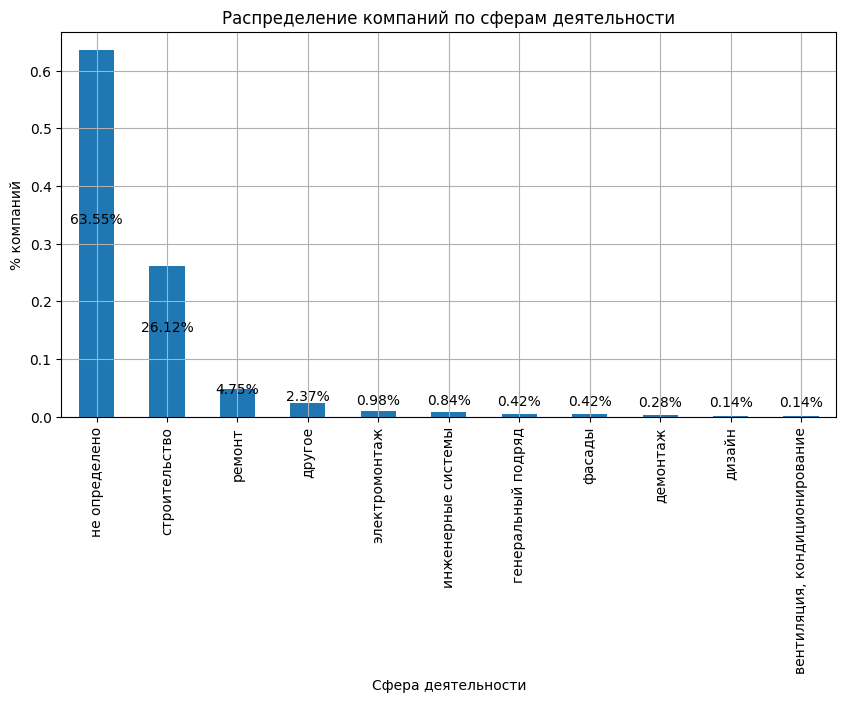

In [73]:
draw_bar_relative(
    companies,
    'working_direction_type',
    'Распределение компаний по сферам деятельности',
    'Сфера деятельности',
    '% компаний',
)

Более четверти компаний работают в сфере строительства, составляя около 26% от общего числа. Примерно 5% занимаются вопросами ремонта. В то же время, большая часть компаний, а именно 63%, не указали свою специализацию, оставив сферу деятельности неопределённой. Интересно, что данные в поле `working_direction`, которое компании заполняют самостоятельно в приложении, изначально были представлены в нестандартизированном виде. Это свидетельствует о том, что приложение не предоставляет заранее определённого списка сфер деятельности для выбора. В рамках предварительной обработки данных был сформирован список 10 основных сфер деятельности на основе существующих ответов, тем самым облегчив последующий анализ и классификацию данных.

### Размеры компании

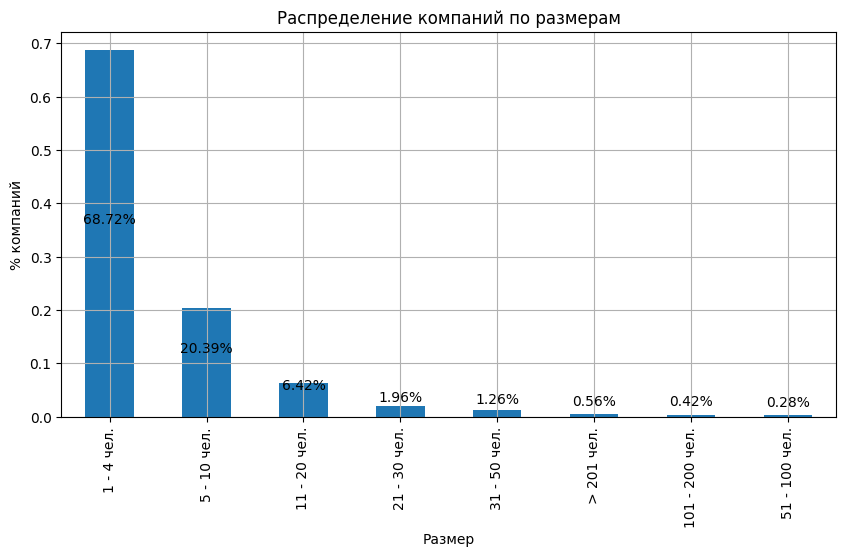

In [74]:
draw_bar_relative(
    companies,
    'employer_count_interval',
    'Распределение компаний по размерам',
    'Размер',
    '% компаний',
)

Проверим, соотвествует ли информация о размере компании действительности. Для начала сгруппируем всех действующих пользователей по компаниям, и найдем распределение значений их количества.

In [75]:
people_by_company = (
    companies
    .merge(people, on='company_id', how='left')
    .query('is_deleted == False')
    .groupby('company_id')['people_id'].nunique()
    .reset_index(name='people_cnt')
)
people_by_company['employer_count_interval'] = people_by_company['people_cnt'].apply(put_employer_count_interval)


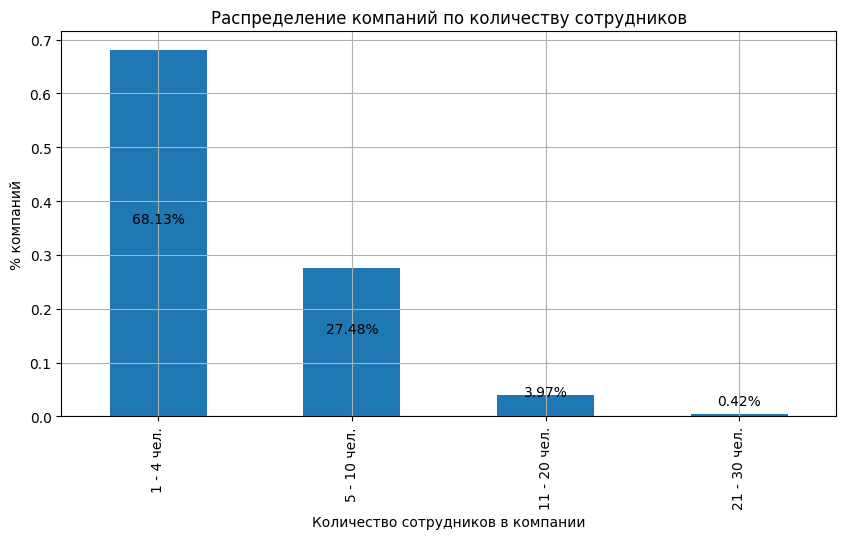

In [76]:
draw_bar_relative(
    people_by_company,
    'employer_count_interval',
    'Распределение компаний по количеству сотрудников',
    'Количество сотрудников в компании',
    '% компаний',
)

Динамика похожа, но различия все-таки есть. Возможно, есть несоотвествие количества сотрудников заявленному типу в информации о компании.

Сравним размер, заявленнный в информации о компании, с полученными данными из таблицы `people` - количество действующих пользователей.

In [77]:
companies_employer_count_interval = companies.merge(people_by_company, on='company_id', how='left')

In [78]:
companies_employer_count_interval.query('employer_count_interval_x < employer_count_interval_y')['company_id'].unique()

array([ 688, 8591,  860,  905,  926,  920, 1330, 1634, 1682, 2300, 2298,
       8338, 2342, 2567, 2484, 2635, 2704, 1935, 2753, 2988, 2968, 3132,
       3067, 3031, 3314, 3348, 3486, 3589, 3674, 3518, 3112, 4121, 4403,
       4411, 4565, 4610, 8408, 4960, 1133, 4972, 5056, 5339, 5466, 8681,
       5585, 5540, 5389, 4394, 8709, 4311, 5979, 6071, 6254,  622, 6326,
       6375, 2263, 1645, 6571, 6663, 6764, 3232, 5432, 6745, 8565, 8761,
        589, 3274, 2227, 2354, 2444, 7084, 7052, 6891, 7142, 8869, 7197,
       8583, 7245, 7308, 7322, 7365, 7371, 7425, 7446, 7542, 8631, 7636,
       7269, 7939, 7971, 8058, 8015, 8219, 8955, 5098, 9086, 9189, 9290,
       9331, 6806, 5411], dtype=int64)

У 102 компаний наблюдаем количество пользователей в системе больше, чем заявленный размер компании. 

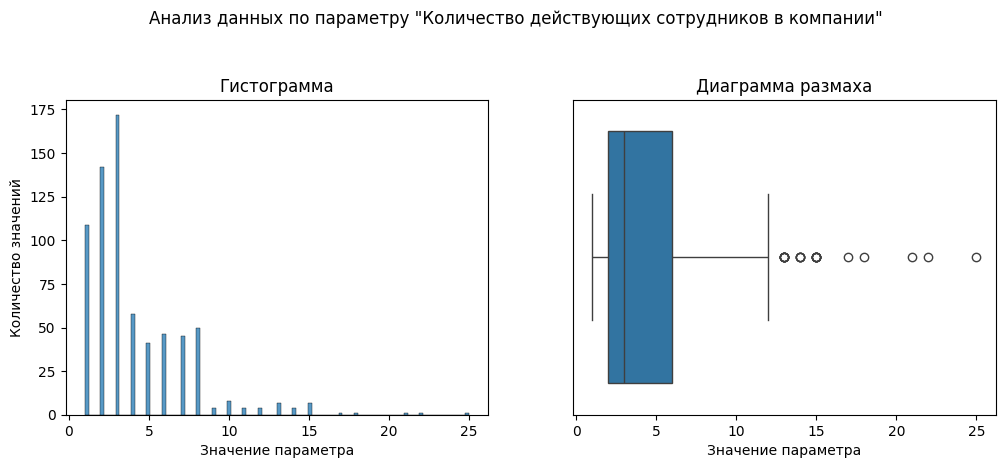

Всего значений: 706

Среднее арифметическое значение: 4.11
Медианное значение: 3.0
В среднем значения варьируются от 2.0 до 6.0
Минимальное значение 1.0
Максимальное значение 25.0


In [79]:
draw_hist_and_box(
    people.query('is_deleted == False').groupby('company_id')['people_id'].nunique().reset_index(name='people_cnt'), 
    'people_cnt', 
)

Основываясь на диаграмме размаха можно сказать, что в среднем количество сотрудников в компании варьируется от 2 до 6. Среднее и медианные значения соотвественно 4 и 3. Встречаются большие значения, максимально - 25.

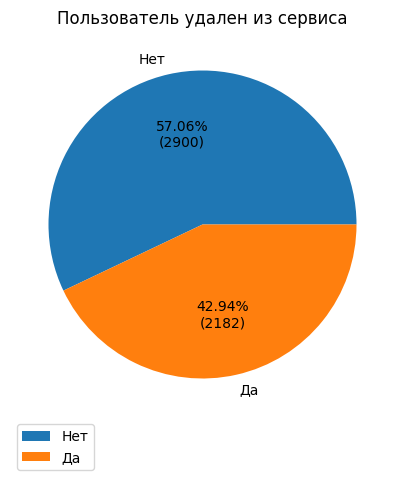

In [80]:
draw_pie(
    people['is_deleted'].value_counts().reset_index(name='cnt').set_index('is_deleted'), 
    'cnt', 
    'Пользователь удален из сервиса'
)

Подавляющее большинство компаний, участвующих в исследовании, демонстрируют малый размер штата: почти 70% из них насчитывают от 1 до 4 сотрудников. Компании с количеством сотрудников от 5 до 10 человек составляют 20-30%, в то время как доля организаций с 11 до 20 работниками приближается к 4-6%. Эта информация подчеркивает склонность к малому и среднему бизнесу среди участников исследования.

Так же стоит обратить внимание нато, что у 102 компаний наблюдаем количество пользователей в системе больше, чем заявленный размер компании. 

### Тарифный план компании

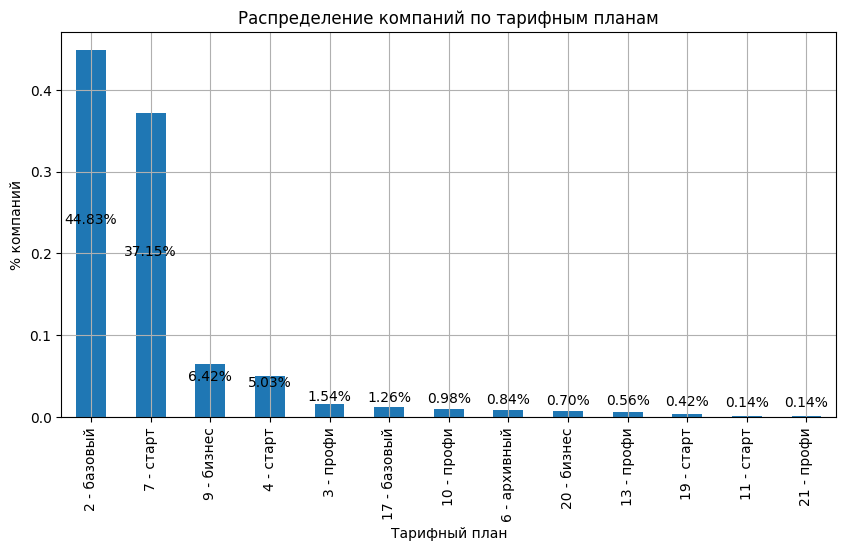

In [81]:
draw_bar_relative(
    companies,
    'billing_tariff_id',
    'Распределение компаний по тарифным планам',
    'Тарифный план',
    '% компаний',
)

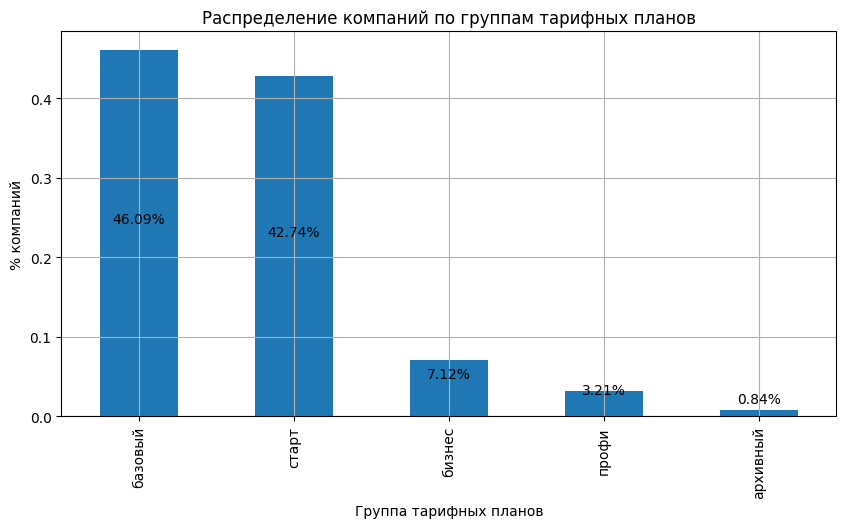

In [82]:
draw_bar_relative(
    companies,
    'billing_tariff_type',
    'Распределение компаний по группам тарифных планов',
    'Группа тарифных планов',
    '% компаний',
)

В рейтинге предпочтений тарифных планов среди компаний лидирующую позицию занимает тариф "базовый" (2), выбранный почти у 45% компаний. На втором месте с отрывом расположился тариф "старт" (7), привлекший внимание 37% компаний. Далее следуют тарифы "бизнес" (9) и "старт" (4) с долями 6,42% и 5,03% соответственно, демонстрируя более узкую аудиторию. Замыкает пятерку лидеров тариф "профи" (3) - 1,54% компаний. Эти данные подчеркивают предпочтения компаний в выборе тарифных планов, отражая стремление к сочетанию доступности и необходимого набора услуг.

Анализ использования групп тарифных планов показал, что "базовые" тарифы предпочитают 45% компаний, за ними следуют "стартовые" с 43%, "бизнес" выбирают 7%, а "профи" - 3%. Архивные тарифы занимают менее 1%.
 
Проверим ниже соотвествует ли эта картина реальным данным о платежах компаний, а так же статистике по активностям.

### Пользователи с неопределенным user_id

In [83]:
print('Количество действующих сотрудников с неопределенным user_id: {}'.format(people.query('user_id == 0 and is_deleted == False')['people_id'].nunique()))
print('Компаний с такими пользователями: {}'.format(people.query('user_id == 0 and is_deleted == False')['company_id'].nunique()))
print(
    'Создание "нулевых" пользователей c {} по {}'
    .format(
        people.query('user_id == 0 and is_deleted == False')['create_date'].min().date(), 
        people.query('user_id == 0 and is_deleted == False')['create_date'].max().date())
)
print(
    'Редактирование "нулевых" пользователей c {} по {}'
    .format(
        people.query('user_id == 0 and is_deleted == False')['update_date'].min().date(), 
        people.query('user_id == 0 and is_deleted == False')['update_date'].max().date())
)



Количество действующих сотрудников с неопределенным user_id: 296
Компаний с такими пользователями: 198
Создание "нулевых" пользователей c 2019-03-09 по 2023-12-11
Редактирование "нулевых" пользователей c 2019-03-09 по 2023-12-11


In [84]:
people.query('is_deleted == True and deleted_at.isna()')

,people_id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at,create_date,update_date,delete_date
6,6749,667,0,9614,1579877137,1579877137,True,NaN,2020-01-24 14:45:37,2020-01-24 14:45:37,NaT
7,6740,667,0,9614,1579179409,1579179409,True,NaN,2020-01-16 12:56:49,2020-01-16 12:56:49,NaT
615,6255,30,0,437,1548944285,1548944285,True,NaN,2019-01-31 14:18:05,2019-01-31 14:18:05,NaT


В таблице с пользователями очень много сотрудников с user_id=0. Так же встречаются записи, где стоит флаг, что пользователь удален, но дата удаления отсутствует.

### Истекла оплата у компании

In [85]:
companies['billing_is_over'].value_counts().reset_index(name='company_cnt')

,billing_is_over,company_cnt
0,True,481
1,False,235


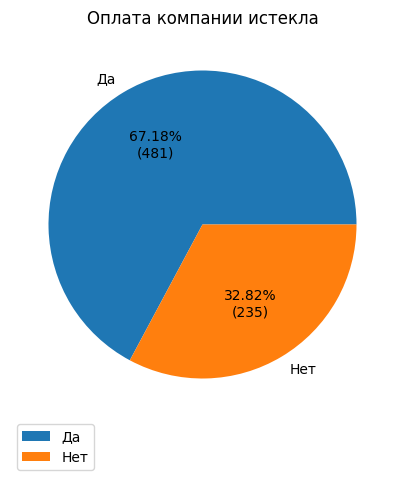

In [86]:
draw_pie(
    companies['billing_is_over'].value_counts().reset_index(name='cnt').set_index('billing_is_over'), 
    'cnt', 
    'Оплата компании истекла'
)

Судя по файлу компаний, только у трети компаний оплата не истекла. 

In [87]:
tariff_is_over = (
    companies
    .pivot_table(index='billing_tariff_id', columns='billing_is_over', values='company_id', aggfunc='nunique', fill_value=0)
)

tariff_is_over['percent'] = round(tariff_is_over[True]/(tariff_is_over[True] + tariff_is_over[False]) * 100, 2)
tariff_is_over.index = tariff_is_over.index.map(dictionary['billing_tariff_id'])

tariff_is_over.sort_values(by='percent', ascending=False)

billing_is_over,False,True,percent
billing_tariff_id,,,
3 - профи,0,11,100.00
11 - старт,0,1,100.00
4 - старт,1,35,97.22
6 - архивный,1,5,83.33
7 - старт,73,193,72.56
2 - базовый,117,204,63.55
10 - профи,3,4,57.14
17 - базовый,4,5,55.56
13 - профи,2,2,50.00


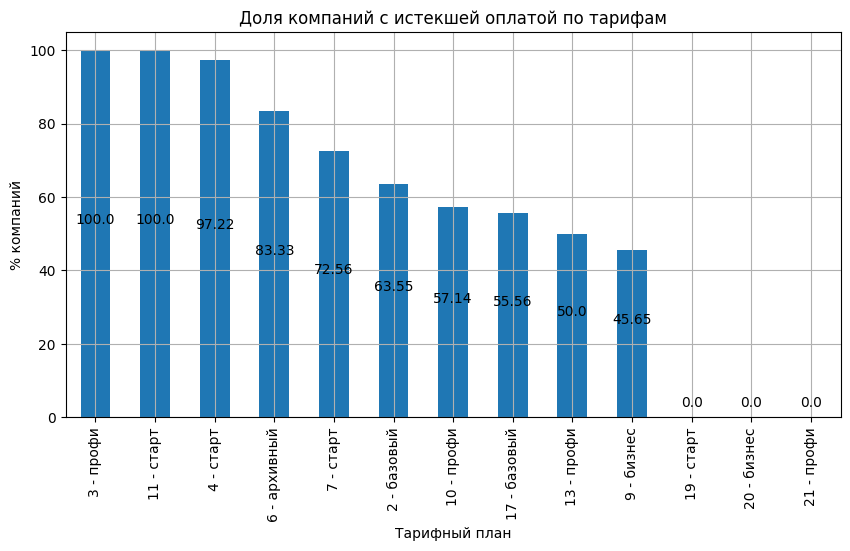

In [88]:
draw_bar(
    tariff_is_over[['percent']].sort_values(by='percent', ascending=False),
    'percent',
    'Доля компаний с истекшей оплатой по тарифам',
    'Тарифный план',
    '% компаний',
    annotate=1
)


Самый высокий процент неоплаты судя по файлу с компаниями на тарифных планах "3-профи" и "11-старт" - 100% неоплата. Высокий процент неоплаты у тарифного плана "4-старт" - 97%, "7-старт" - 73%, "2-базовый" - 64%. По тарифам "19-старт", "20-бизнес" и "21-профи" оплата всегда была, но таких компаний очень мало. Необходимо сравнить эти результаты с анализом данных из таблицы с платежами.

### Должности сотрудников

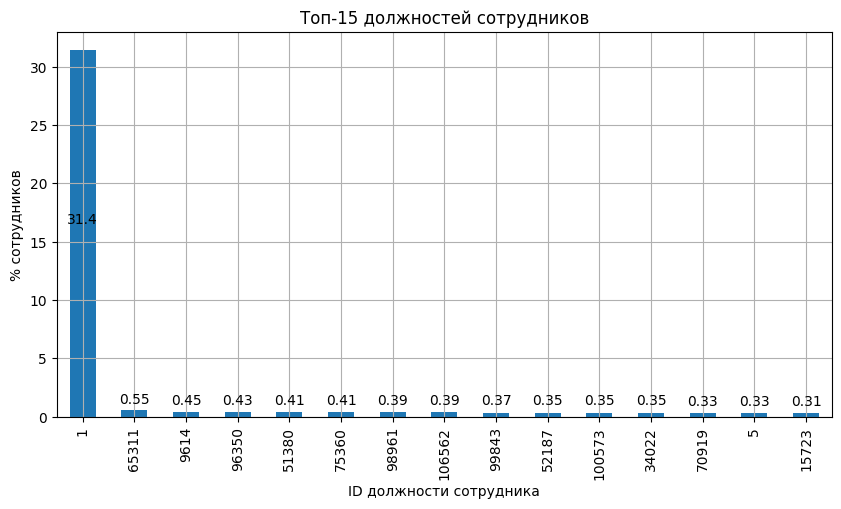

In [89]:
roles = (
    (
        people['role_id']
        .value_counts(normalize=True) * 100
    )
    .round(2)
    .reset_index(name='cnt')
    .set_index('role_id')
    .sort_values(by='cnt', ascending=False)
)

draw_bar(
    roles.head(15),
    'cnt',
    'Топ-15 должностей сотрудников',
    'ID должности сотрудника',
    '% сотрудников',
    annotate=1
)


Около 30% всех должностей сотрудников занимает должность с ID равным 1. Все остальные должности в системе менее 1 процента, и их очень много.

### Распределение по датам

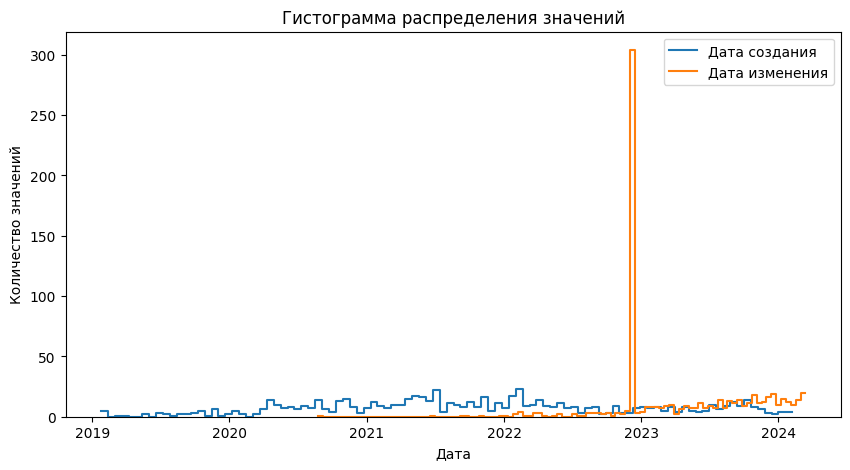

In [90]:
draw_hist_by_date(
    companies, 
    ['create_date', 'update_date']
)

In [91]:
companies['update_date'].value_counts().head(1)

update_date
2022-12-06 03:45:53    6
Name: count, dtype: int64

Наблюдается огромный всплеск активности при изменении данных по компаниям 6 декабря 2022 года. Возможно массовая смена тарифных планов, или какие то другие изменения в данных, проверим эту гипотезу ниже.

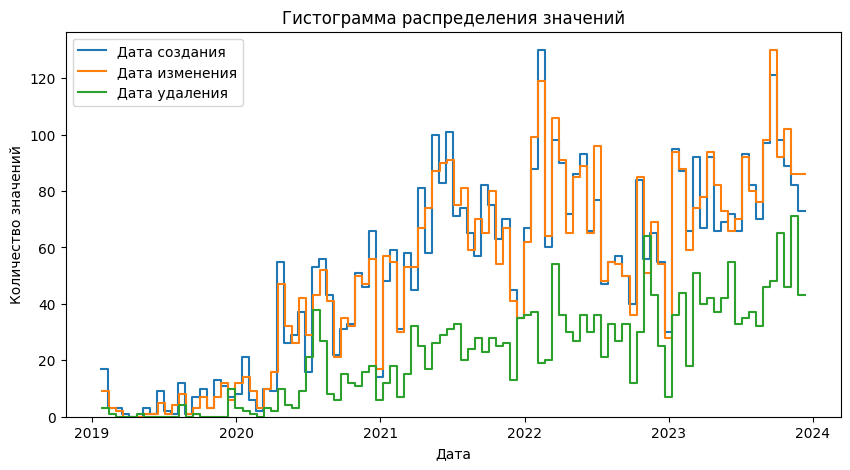

In [92]:
draw_hist_by_date(
    people, 
    ['create_date', 'update_date', 'delete_date']
)

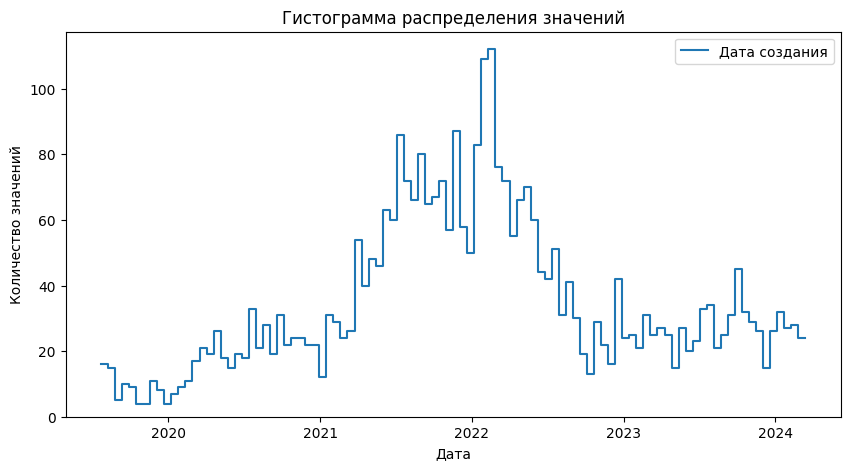

In [93]:
draw_hist_by_date(
    billing, 
    ['create_date']
)



На графиках по датам в таблице `people` и `billing` не наблюдаем никаких всплесков на конец 2022 года.

### Вывод

- Количество уникальных компаний: 716
- Количество уникальных сфер деятельности компании: 11
- Количество уникальных размеров компании: 8
- Количество уникальных тарифных планов: 13
- Количество уникальных групп тарифных планов: 5
- Регистрация компаний c 2019-01-23 по 2024-02-07
- Изменение данных о компаниях c 2020-08-24 по 2024-03-13
- Количество уникальных сотрудников: 5082
- Количество уникальных должностей: 1411
- Создание пользователей c 2019-01-23 по 2023-12-13
- Редактирование пользователей c 2019-01-25 по 2023-12-13
- Удаление пользователей c 2019-01-25 по 2023-12-13


Более четверти компаний работают **в сфере строительства, составляя около 26%** от общего числа. Примерно 5% занимаются вопросами ремонта. В то же время, большая часть компаний, а именно 63%, не указали свою специализацию, оставив сферу деятельности неопределённой. Интересно, что данные в поле `working_direction`, которое компании заполняют самостоятельно в приложении, изначально были представлены в нестандартизированном виде. Это свидетельствует о том, что приложение не предоставляет заранее определённого списка сфер деятельности для выбора. В рамках предварительной обработки данных был сформирован список 10 основных сфер деятельности на основе существующих ответов, тем самым облегчив последующий анализ и классификацию данных.

Подавляющее большинство компаний, участвующих в исследовании, демонстрируют малый размер штата: **почти 70% из них насчитывают от 1 до 4 сотрудников**. Компании с количеством сотрудников от 5 до 10 человек составляют 20-30%, в то время как доля организаций с 11 до 20 работниками приближается к 4-6%. Эта информация подчеркивает склонность к малому и среднему бизнесу среди участников исследования.

Так же стоит обратить внимание на то, что у 102 компаний наблюдаем количество пользователей в системе **больше, чем заявленный размер компании**.

В рейтинге предпочтений тарифных планов среди компаний лидирующую позицию занимает тариф **"базовый" (2), выбранный почти у 45% компаний**. На втором месте с отрывом расположился тариф "старт" (7), привлекший внимание 37% компаний. Далее следуют тарифы "бизнес" (9) и "старт" (4) с долями 6,42% и 5,03% соответственно, демонстрируя более узкую аудиторию. Замыкает пятерку лидеров тариф "профи" (3) - 1,54% компаний. Эти данные подчеркивают предпочтения компаний в выборе тарифных планов, отражая стремление к сочетанию доступности и необходимого набора услуг.

Анализ использования групп тарифных планов показал, что **"базовые" тарифы предпочитают 45% компаний**, за ними следуют "стартовые" с 43%, "бизнес" выбирают 7%, а "профи" - 3%. Архивные тарифы занимают менее 1%.

В таблице с пользователями очень много сотрудников с **user_id=0**. Так же встречаются записи, где стоит флаг, что **пользователь удален, но дата удаления отсутствует**.

Судя по файлу компаний, только у трети компаний оплата не истекла.

Самый **высокий процент неоплаты на тарифных планах "3-профи" и "11-старт" - 100% неоплата**. Высокий процент неоплаты у тарифного плана "4-старт" - 97%, "7-старт" - 73%, "2-базовый" - 64%. По тарифам **"19-старт", "20-бизнес" и "21-профи" оплата всегда была**, но таких компаний очень мало.

Около 30% всех должностей сотрудников занимает должность с ID равным 1. Все остальные должности в системе менее 1%, и их очень много.

Наблюдается огромный всплеск активности при изменении данных по компаниям 6 декабря 2022 года. Возможно массовая смена тарифных планов, или какие то другие изменения в данных.


## Проверка гипотез

In [94]:
print('Всего в таблице с платежами {} записей'.format(billing.shape[0]))
print('-'*100)
print('Уникальных компаний: {}'.format(billing['company_id'].nunique()))
print('Уникальных тарифных планов: {}'.format(billing['billing_tariff_id'].nunique()))
print('Уникальных ценовых тарифов: {}'.format(billing['billing_tariff_price_id'].nunique()))
print(
    'Создание операций c {} по {}'
    .format(billing['create_date'].min().date(), billing['create_date'].max().date()
    )
)
print(
    '"Подписка до" c {} по {}'
    .format(billing['until_date'].min().date(), billing['until_date'].max().date()
    )
)


Всего в таблице с платежами 3479 записей
----------------------------------------------------------------------------------------------------
Уникальных компаний: 1841
Уникальных тарифных планов: 13
Уникальных ценовых тарифов: 47
Создание операций c 2019-07-23 по 2024-03-13
"Подписка до" c 2019-09-11 по 2033-04-10


Видно, что компаний в датасете companies гораздо меньше, впрочем как и в датасете activities. На это стоит обратить внимание разработчикам.

### Поиск целевых пользователей

Целевыми пользователя будем считать таких пользователей у которых в таблице платежей есть платеж с датой продления позже, чем дата текущего анализа, независимо от того, оплатила компания или нет. 

Промаркируем все записи в таблице биллинга флагом последняя эта запись по компании или нет.

In [95]:
idx_last_row = (
    billing
    .sort_values(by=['company_id', 'payed_until'], ascending=True)
    .groupby('company_id')
    .tail(1)
    .index
)
billing['payment_is_last'] = False
billing.loc[idx_last_row, 'payment_is_last'] = True


Теперь промаркируем все записи в таблице биллинга флагом, является ли запись, до которой продлен платеж, подходящий под наш анализ на целевое событие. Т.е. дата продления позже, чем дата анализа.

In [96]:
billing['payment_is_active'] = False
billing.loc[billing['until_date'] > pd.to_datetime(start_date), 'payment_is_active'] = True


Компания считает активной, если у нее есть хотя бы один платеж, позже, чем дата анализа, все остальные компании будем считать ушедшими.

Получим список компаний, у которых есть такие платежи, после чего промаркируем все платежи таких компаний еще один флагом - "компания активна".

In [97]:
company_is_active = billing.query('payment_is_active == True')['company_id'].unique()

billing['company_is_active'] = False
billing.loc[billing['company_id'].isin(company_is_active), 'company_is_active'] = True


Если запись в датасете платежей по компании последняя, то оставляем эту запись, ровно как и все записи по всем клиентам, помеченные флагом - "оплачено" (анализ в разрезе времени). Эти записи будем считать актуальными, остальные данные нам не нужны, потому что они похожи на автоматическое действие сервиса, которое потом компания не оплачивает.


In [98]:
#billing = billing.query('is_payed == True or (payment_is_last == True and payment_is_active == True)')
billing = billing.query('is_payed == True or payment_is_last == True')

### Количество активных компаний из биллинга

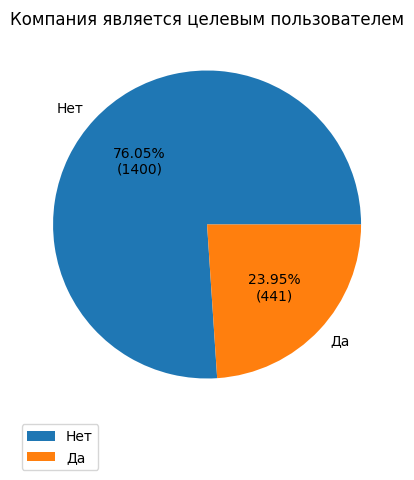

In [99]:
draw_pie(
    billing.groupby('company_is_active')['company_id'].nunique().reset_index(name='cnt').set_index('company_is_active'),
    'cnt', 
    'Компания является целевым пользователем'
)

Согласно таблице биллинга только 24 % компаний являются действующими на данный момент. Так же необходимо обратить внимание, что несмотря на то, что мы удалили несущественные записи, количество компаний все так же отличается от файла с компаниями, и файла с активностями по компаниям (716 против 1841 компаний, в биллинге их больше более, чем в 2 раза). 

Найдем такие компании, у которых только 1 запись в таблице биллинга.

In [100]:
company_with_one_payment = billing.groupby('company_id').filter(lambda x: len(x) == 1)

print(
    'Процент компаний с одним платежом в таблице биллинга {:.2%} ({} компаний).'
    .format(
        company_with_one_payment['company_id'].nunique()/billing['company_id'].nunique(),
        company_with_one_payment['company_id'].nunique()
    )
)

Процент компаний с одним платежом в таблице биллинга 86.31% (1589 компаний).


In [101]:
companies_with_one_payment_not_payed = company_with_one_payment[company_with_one_payment['is_payed'] == False]

print(
    'Процент компаний только с одним платежом, который не был оплачен {:.2%} ({} компаний).'
    .format(
        companies_with_one_payment_not_payed['company_id'].nunique()/billing['company_id'].nunique(),
        companies_with_one_payment_not_payed['company_id'].nunique()
    )
)


Процент компаний только с одним платежом, который не был оплачен 57.69% (1062 компаний).


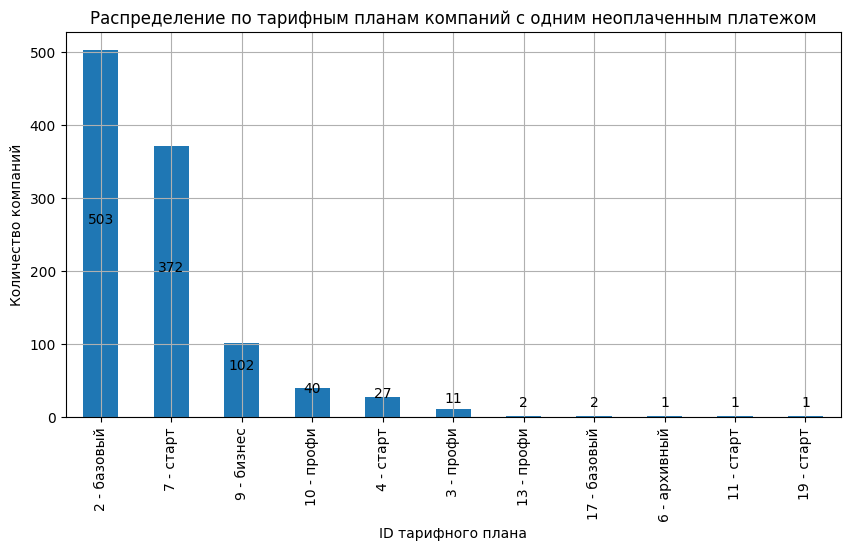

In [102]:
tariff_stat = companies_with_one_payment_not_payed['billing_tariff_id'].value_counts()
tariff_stat.index = tariff_stat.index.map(dictionary['billing_tariff_id'])
tariff_stat.sort_values()

draw_bar(
    tariff_stat,
    'billing_tariff_type',
    'Распределение по тарифным планам компаний с одним неоплаченным платежом',
    'ID тарифного плана',
    'Количество компаний',
    annotate=1
)


### Среднее время длительности подписки по одному платежу

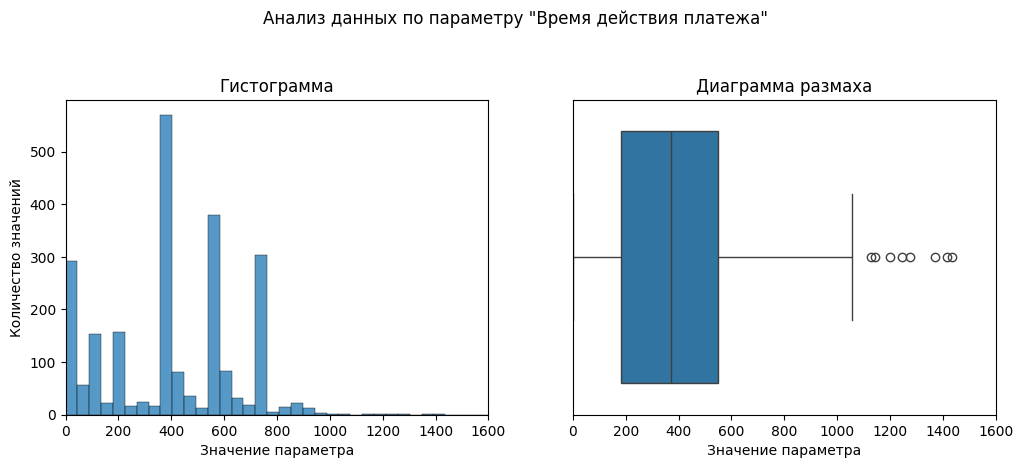

Всего значений: 2333

Среднее арифметическое значение: 402.92
Медианное значение: 373.0
В среднем значения варьируются от 183.0 до 548.0
Минимальное значение -1.0
Максимальное значение 4493.0


In [103]:
draw_hist_and_box(billing, 'payment_life', 100, 0, 1600)

In [104]:
billing['payment_life'].value_counts().reset_index().head(5)

,payment_life,count
0,364,214
1,729,179
2,365,102
3,545,100
4,546,92


В среднем подписка по одному платежу действует 1 год, наблюдаем так же пики в районе 1.5 и 2 года.

Изучим, как продолжительность платежа зависит от активности компании.

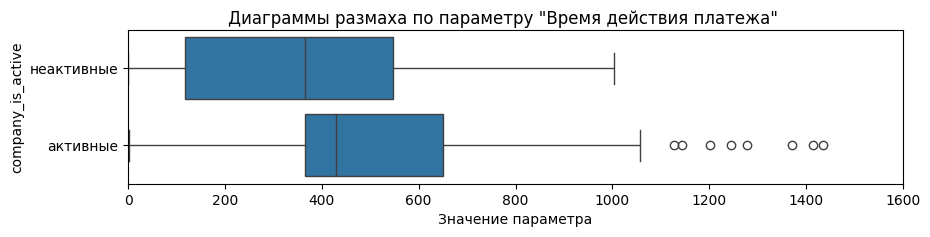

In [105]:
draw_box(billing, 'payment_life', 'company_is_active', 0, 1600)

Компании, которые ушли с сервиса в среднем ранее оплачивали платеж на год, в то время как активные компании оплачивают в среднем дольше, чем на 1 год.

### Анализ оперативности оплаты платежа

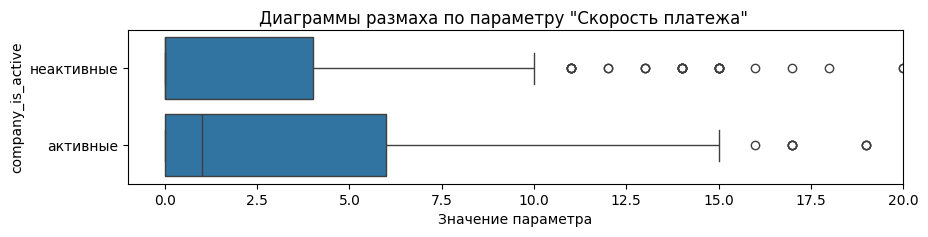

In [106]:
draw_box(billing.query('pay_date > 0'), 'payment_speed', 'company_is_active', -1, 20)

Неактивные компании сразу оплачивали свой платеж, разница между датой создания платежа и датой оплаты равно 0, при этом из исследования выпало огромное количество платежей, которые так и не были оплачены. Компании, которые продолжают быть активными в сервисе оплачивают сервис в течении недели.

### Анализ количества платежей по компаниям

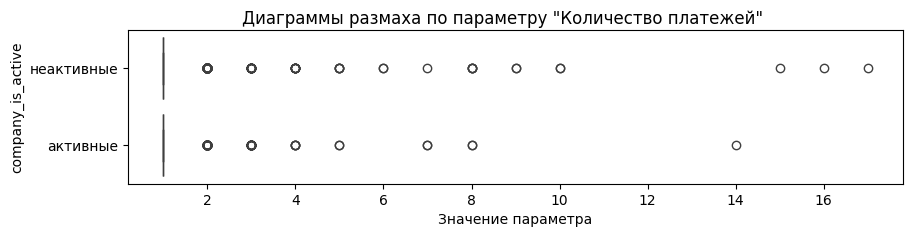

In [107]:
draw_box(
    (
        billing
        .groupby('company_id')
        .agg(
            {
                'company_is_active': 'last', 
                'billing_id': 'count',
            }
        )
        .rename(
            columns={
                'billing_id': 'payment_cnt', 
            }
        )
    ),
    'payment_cnt', 
    'company_is_active',
)

Количество платежей по обеим категориям в среднем равно одному, есть аномалии, компании у которых было до 17 платежей.

### Анализ количества оплаченных платежей

Все платежи, которые мы оставили в датасете billing по ушедшим компаниям будут оплачены, потому что мы оставили все оплачены и все действующие. Действующих у ушедших компаний нет. Посмотрим статистику по текущий клиентам, какая доля платежей оплачена, а какая нет.

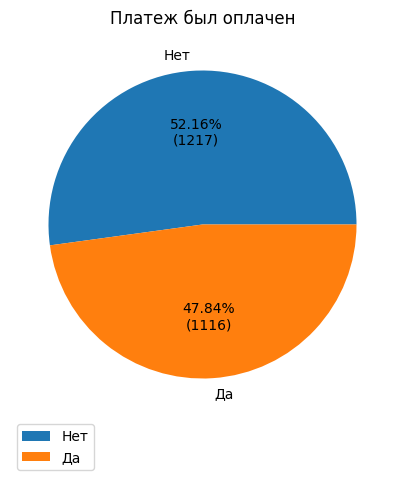

In [108]:
draw_pie(
    billing['is_payed'].value_counts().reset_index(name='cnt').set_index('is_payed'),
    'cnt', 
    'Платеж был оплачен'
)

Согласно биллингу только 48% всех платежей были оплачены пользователями.

### Взаимосвязь ID тарифа и ID стоимости тарифа

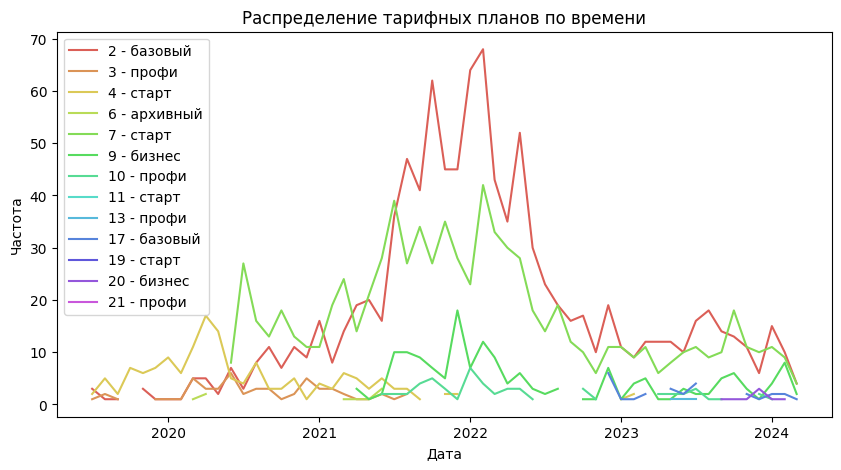

In [109]:
draw_plot(
    billing.pivot_table(index='create_month', columns='billing_tariff_id', values='billing_id', aggfunc='count'), 
    'billing_tariff_id',
    'Распределение тарифных планов по времени', 
    'Дата', 
    'Частота'
)

Видно, что со временем какие то тарифные планы пропадают, а какие то наоборот появляются. Например, тарифный план "3-профи" почти не используется с 2022 года, в то время как тарифные планы  "17-базовый", "19-старт", "20-бизнес" и "21-профи" появились.

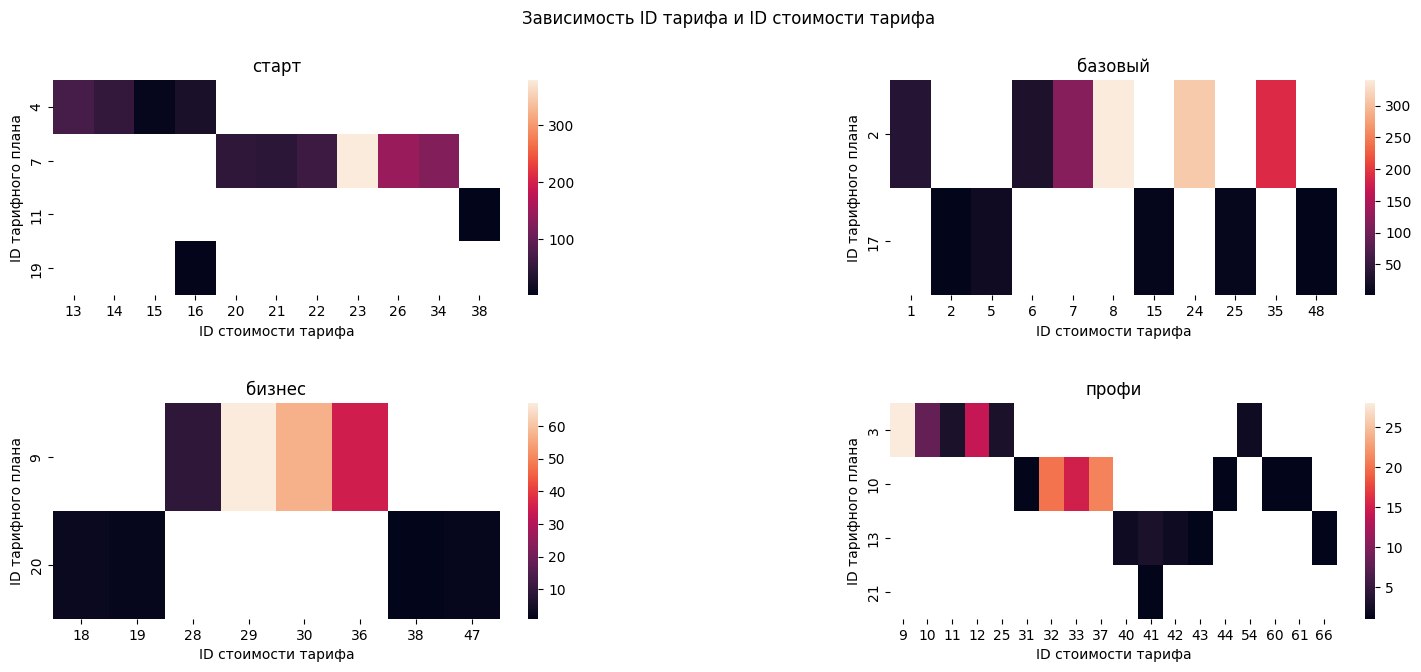

In [110]:
plt.figure(figsize=(18, 7))
    
plt.suptitle('Зависимость ID тарифа и ID стоимости тарифа')
        
i = 1
for name in dic_billing_tariff_group:

    if name == 0:
        continue

    plt.subplot(2,2,i)
    i += 1
    
    tariff_list = dic_billing_tariff_group[name]

    sns.heatmap(
        billing
        .query('billing_tariff_id in @tariff_list')
        .pivot_table(index='billing_tariff_id', columns='billing_tariff_price_id', values='billing_id', aggfunc='count')
    )
    
    # Оформление графика
    plt.title(dictionary['billing_tariff_type'][name])
    plt.xlabel('ID стоимости тарифа')
    plt.ylabel('ID тарифного плана')
            
# Оформление графика
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Отображение графика
plt.show()


In [111]:
billing.query('billing_tariff_id == 4')['create_date'].max()

Timestamp('2023-02-28 06:35:28')

In [112]:
billing.query('billing_tariff_id == 19')['create_date'].min()

Timestamp('2023-07-10 05:12:01')

In [113]:
billing.query('billing_tariff_id == 13')['create_date'].max()

Timestamp('2024-01-15 19:08:58')

In [114]:
billing.query('billing_tariff_id == 21')['create_date'].min()

Timestamp('2023-09-12 10:09:24')

Анализ структуры тарифных планов и их стоимости выявил интересную закономерность: в большинстве случаев каждая комбинация ID тарифа и ID стоимости является уникальной в пределах одного тарифного плана. Это подчеркивает структурированность и организованность тарифной политики. Однако были обнаружены исключения, которые придают системе тарификации дополнительную гибкость.

В частности, в рамках тарифной группы "старт", ID стоимости 16 объединяет в себе не только тариф "4-старт", но и "19-старт", демонстрируя перекрестную применимость стоимости между различными тарифными планами внутри одной группы. Аналогичная ситуация наблюдается и в тарифной группе "профи", где ID стоимости 41 связывает тарифы "13-профи" и "21-профи". Такие пересечения могут свидетельствовать о выделение нового тарифного плана из тарифной группы, например, для "старт" эта гипотеза подтвержается (тарифные планы "4-старт" и "19-старт" используются в разное время). Что же касается тарифных планов "13-профи" и "21-профи", то тут необходимо уточнение у заказчика).


### Проверка гипотезы: есть зависимость уходов от тарифного плана

Для проверки гипотез независимости двух категориальных переменных будем использовать метод chi2_contingency из библиотеки SciPy. Он основан на критерии хи-квадрат (χ²) Пирсона для таблиц сопряженности (таблиц контингенции), которые показывают распределение частот комбинаций категорий двух переменных.

**Нулевая гипотеза H0:** между тарифным планом и уходом пользователя из сервиса нет статистически значимой связи.

**Альтернативная гипотеза H1:** между тарифным планом и уходом пользователя из сервиса существует статистически значимая связь. 

Гипотезу будем проверять только на основе последних платежей по каждой компании, если дата продления выше текущей, то считаем, что компания целевая. Проверим как ID тарифного плана влияет на целевую переменную.

In [115]:
check_chi2_hypothesis(billing.query('payment_is_last == True'), 'billing_tariff_id', 'company_is_active')

Chi-squared: 75.50352851057147, p-value: 2.95075231136696e-11
Отвергаем нулевую гипотезу: между категориями есть значимая разница


Значение p-value меньше выбранного уровня статистической значимости (alpha = 0.05), нулевая гипотеза отвергается в пользу альтернативной, что указывает на наличие статистически значимой зависимости между переменными.

Построим графики распределения тарифных планов по времени для каждой группы пользователей отдельно и сравним их.

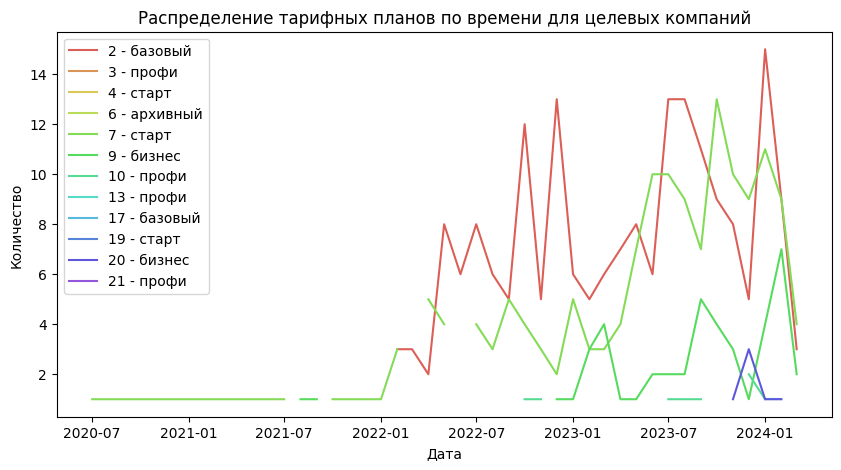

In [116]:
draw_plot(
    (
        billing
        .query('company_is_active == True and payment_is_last == True')
        .pivot_table(index='create_month', columns='billing_tariff_id', values='company_id', aggfunc='count')
    ), 
    'billing_tariff_id',
    'Распределение тарифных планов по времени для целевых компаний', 
    'Дата', 
    'Количество'
)

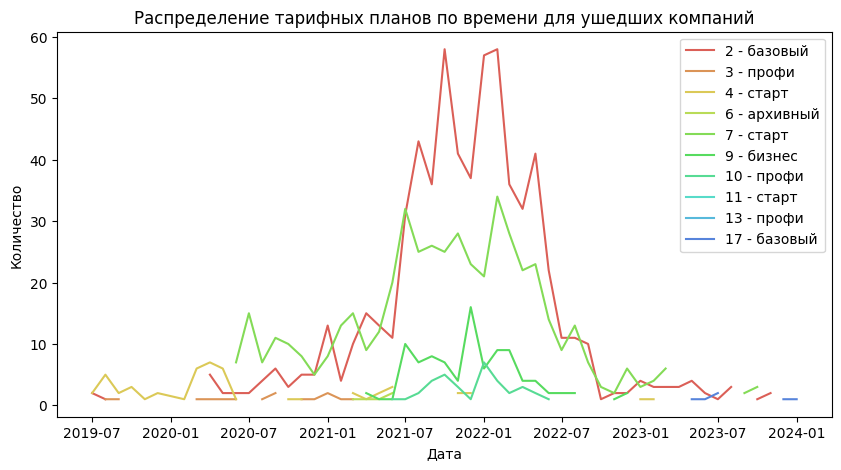

In [117]:
draw_plot(
    (
        billing
        .query('company_is_active == False and payment_is_last == True')
        .pivot_table(index='create_month', columns='billing_tariff_id', values='company_id', aggfunc='count')
    ), 
    'billing_tariff_id',
    'Распределение тарифных планов по времени для ушедших компаний', 
    'Дата', 
    'Количество'
)

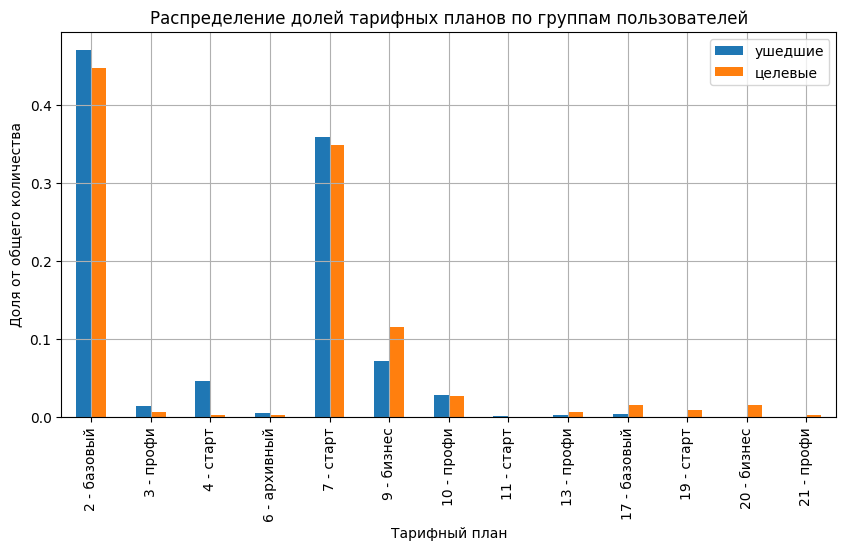

In [118]:
billing_tariff = (
    billing
    .query('payment_is_last == True')
    .pivot_table(index='billing_tariff_id', columns='company_is_active', values='company_id', aggfunc='count')
    .rename(columns={
        True: 'целевые',
        False: 'ушедшие',
    })
)
billing_tariff.index = billing_tariff.index.map(dictionary['billing_tariff_id'])

draw_bar_сompare(
    billing_tariff.div(billing_tariff.sum(axis=0), axis=1),
    'Распределение долей тарифных планов по группам пользователей',
    'Тарифный план',
    'Доля от общего количества',
    annotate=1
)

По графикам видно, что в обеих группах популярностью пользуются тарифные планы "2-базовый" и "7-старт", при этом в группе с ушедшими эти доли чуть больше. В тоже время для целевых пользователей характерна более высокая доля тарифного плана "9-бизнес". Так же для целевых пользователей характерно наличие тарифных планов "19-старт", "20-бизнес" и "21-профи", среди ушедших пользователей таких тарифных планов нет, это может свидетельствовать о недавнем появление новых тарифов.

Сгруппируем все тарифы в группы, и проверим тоже самое на основе тарифных групп.

In [119]:
check_chi2_hypothesis(billing.query('payment_is_last == True'), 'billing_tariff_type', 'company_is_active')


Chi-squared: 16.47518078150381, p-value: 0.0024435354845814446
Отвергаем нулевую гипотезу: между категориями есть значимая разница


Значение p-value меньше выбранного уровня статистической значимости (alpha = 0.05), нулевая гипотеза отвергается в пользу альтернативной, что указывает на наличие статистически значимой зависимости между переменными.

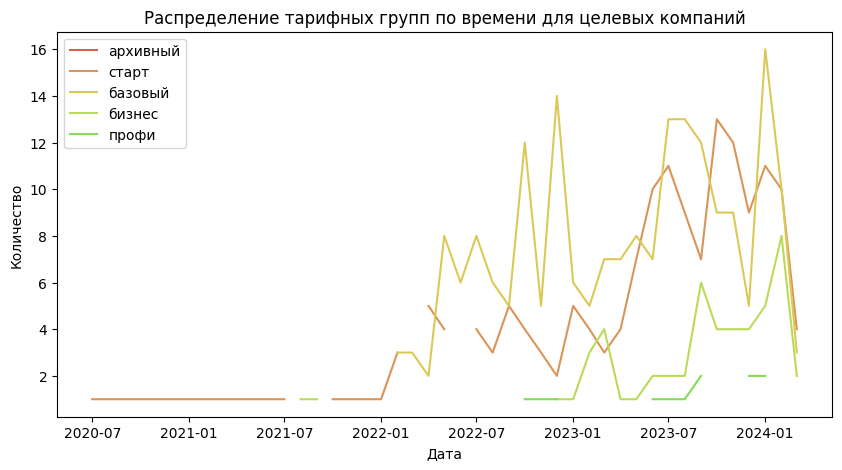

In [120]:
draw_plot(
    (
        billing
        .query('company_is_active == True and payment_is_last == True')
        .pivot_table(index='create_month', columns='billing_tariff_type', values='company_id', aggfunc='count')
    ), 
    'billing_tariff_type',
    'Распределение тарифных групп по времени для целевых компаний', 
    'Дата', 
    'Количество'
)

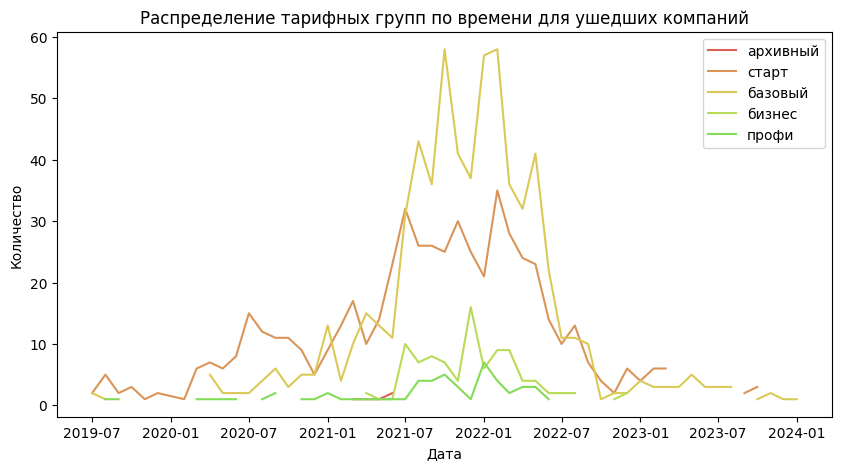

In [121]:
draw_plot(
    (
        billing
        .query('company_is_active == False and payment_is_last == True')
        .pivot_table(index='create_month', columns='billing_tariff_type', values='company_id', aggfunc='count')
    ), 
    'billing_tariff_type',
    'Распределение тарифных групп по времени для ушедших компаний', 
    'Дата', 
    'Количество'
)

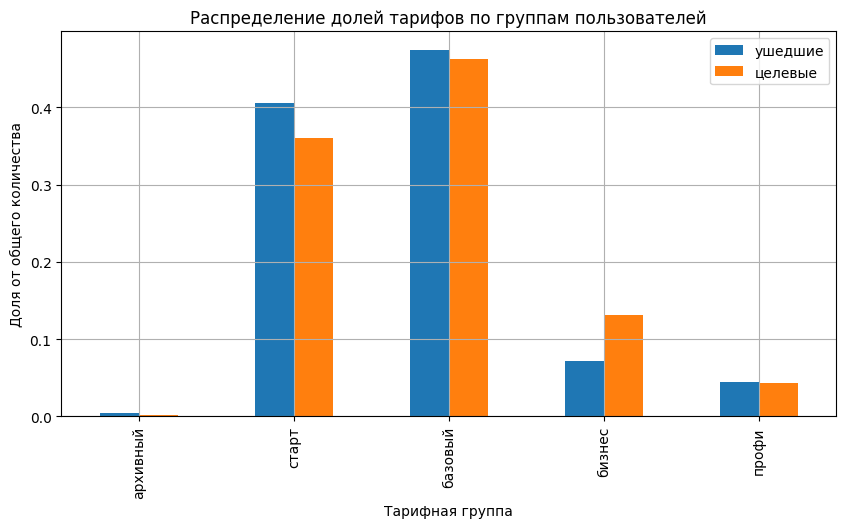

In [122]:
billing_tariff = (
    billing
    .query('payment_is_last == True')
    .pivot_table(index='billing_tariff_type', columns='company_is_active', values='company_id', aggfunc='count')
    .rename(columns={
        True: 'целевые',
        False: 'ушедшие',
    })
)
billing_tariff.index = billing_tariff.index.map(dictionary['billing_tariff_type'])

draw_bar_сompare(
    billing_tariff.div(billing_tariff.sum(axis=0), axis=1),
    'Распределение долей тарифов по группам пользователей',
    'Тарифная группа',
    'Доля от общего количества',
    annotate=1
)

Можно с увереность сказать, что есть статистическая разница между целевым событием и выбором тарифного плана. В группе с целевыми пользователями тариф "бизнес" используется чаще, чем для ушедших компаний.

Сгруппируем все последние платежи по всем компаниям в сводную таблице по ID тарифного плана в разрезе активности компании. Посчитаем количество в каждой группе. 

Найдем долю целевых компаний по каждому тарифному плану.

company_is_active,False,True,percent
billing_tariff_id,,,
19 - старт,0,4,100.00
20 - бизнес,0,7,100.00
21 - профи,0,1,100.00
17 - базовый,6,7,53.85
13 - профи,3,3,50.00
9 - бизнес,100,51,33.77
10 - профи,39,12,23.53
7 - старт,502,154,23.48
2 - базовый,658,197,23.04


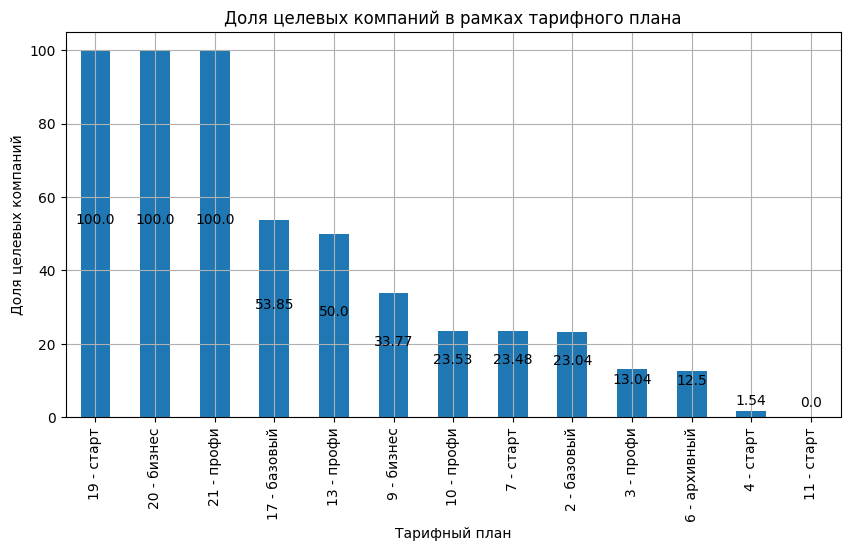

In [123]:
tariff_pivot = (
    billing
    .query('payment_is_last == True')
    .pivot_table(index='billing_tariff_id', columns='company_is_active', values='company_id', aggfunc='count', fill_value=0)
)

tariff_pivot['percent'] = round(tariff_pivot[True]/(tariff_pivot[True] + tariff_pivot[False]) * 100, 2)
tariff_pivot.index = tariff_pivot.index.map(dictionary['billing_tariff_id'])
display(tariff_pivot.sort_values(by='percent', ascending=False))

draw_bar(
    tariff_pivot[['percent']].sort_values(by='percent', ascending=False),
    'percent',
    'Доля целевых компаний в рамках тарифного плана',
    'Тарифный план',
    'Доля целевых компаний',
    annotate=1
)


Не рассмотривая самые малочисленные тарифные планы, в которых насчитается до 10 компаний, можно сказать, что доля целевых пользователей на тарифном плане "9-бизнес" самая высокая среди всех тарифных планов 34%.

company_is_active,False,True,percent
billing_tariff_type,,,
бизнес,100,58,36.71
базовый,664,204,23.50
профи,62,19,23.46
старт,567,159,21.90
архивный,7,1,12.50


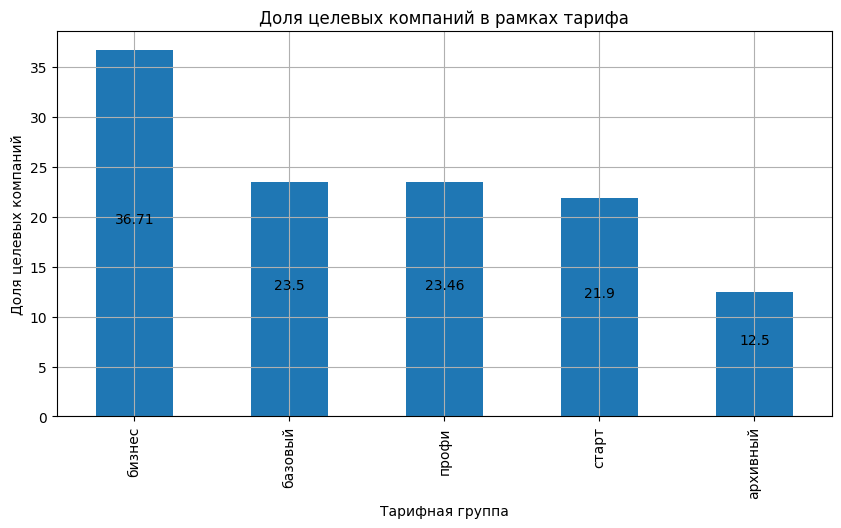

In [124]:
tariff_type_pivot = (
    billing
    .query('payment_is_last == True')
    .pivot_table(index='billing_tariff_type', columns='company_is_active', values='company_id', aggfunc='count', fill_value=0)
)

tariff_type_pivot['percent'] = round(tariff_type_pivot[True]/(tariff_type_pivot[True] + tariff_type_pivot[False]) * 100, 2)
tariff_type_pivot.index = tariff_type_pivot.index.map(dictionary['billing_tariff_type'])
display(tariff_type_pivot.sort_values(by='percent', ascending=False))

draw_bar(
    tariff_type_pivot[['percent']].sort_values(by='percent', ascending=False),
    'percent',
    'Доля целевых компаний в рамках тарифа',
    'Тарифная группа',
    'Доля целевых компаний',
    annotate=1
)


### Проверка гипотезы: есть зависимость уходов от размера компании

In [125]:
companies_stat = (
    companies_employer_count_interval
    .merge(
        billing[['company_id', 'company_is_active', 'payment_is_last']].drop_duplicates(), 
        on='company_id', 
        how='left'
    )[['company_id', 'employer_count_interval_x', 'employer_count_interval_y', 'company_is_active', 'payment_is_last']]
    .rename(columns={
        'employer_count_interval_x': 'employer_count_interval',
        'employer_count_interval_y': 'employer_count_interval_calc',
    })
)

Для проверки гипотез независимости двух категориальных переменных будем использовать метод chi2_contingency из библиотеки SciPy. Он основан на критерии хи-квадрат (χ²) Пирсона для таблиц сопряженности (таблиц контингенции), которые показывают распределение частот комбинаций категорий двух переменных.

**Нулевая гипотеза H0:** между размером компании и уходом пользователя из сервиса нет статистически значимой связи.

**Альтернативная гипотеза H1:** между размером компании и уходом пользователя из сервиса существует статистически значимая связь.

Гипотезу будем проверять только на основе последних платежей по каждой компании, если дата продления выше текущей, то считаем, что компания целевая. Проверим как количество сотрудников в компании влияет на целевую переменную.

Сначала рассмотрим признак размер компании из описания самой компании.

In [126]:
check_chi2_hypothesis(companies_stat.query('payment_is_last == True'), 'employer_count_interval', 'company_is_active')

Chi-squared: 5.351809852215965, p-value: 0.6171132464037232
Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между категориями есть значимая разница


Нет достаточных оснований для отвержения нулевой гипотезы, что указывает на вероятную независимость переменных.

Рассмотрим размер компании, как количество действующих сотрудников в компании из таблицы `people`, напомним, что есть несоответствие типов, для 102 компаний размер компании указан меньше, чем фактический.

In [127]:
check_chi2_hypothesis(companies_stat.query('payment_is_last == True'), 'employer_count_interval_calc', 'company_is_active')

Chi-squared: 12.154928141960063, p-value: 0.006870853717230558
Отвергаем нулевую гипотезу: между категориями есть значимая разница


Значение p-value меньше выбранного уровня статистической значимости (alpha = 0.05), нулевая гипотеза отвергается в пользу альтернативной, что указывает на наличие статистически значимой зависимости между переменными.

В результате несовпадения данных о размере компании значимость зависимости между размером и целевым событием не возможно не подтвердить, не опровергунь. Подтвердим выше изложенные выводы данными.

In [128]:
employer_count_interval_pivot = (
    companies_stat
    .query('payment_is_last == True')
    .pivot_table(index='employer_count_interval', columns='company_is_active', values='company_id', aggfunc='count', fill_value=0)
)

employer_count_interval_pivot['percent'] = round(employer_count_interval_pivot[True]/(employer_count_interval_pivot[True] + employer_count_interval_pivot[False]) * 100, 2)
employer_count_interval_pivot.index = employer_count_interval_pivot.index.map(dictionary['employer_count_interval'])
display(employer_count_interval_pivot.sort_values(by='percent', ascending=False))



company_is_active,False,True,percent
employer_count_interval,,,
101 - 200 чел.,1,2,66.67
51 - 100 чел.,1,1,50.00
> 201 чел.,2,2,50.00
31 - 50 чел.,5,4,44.44
11 - 20 чел.,26,20,43.48
5 - 10 чел.,90,56,38.36
21 - 30 чел.,9,5,35.71
1 - 4 чел.,330,162,32.93


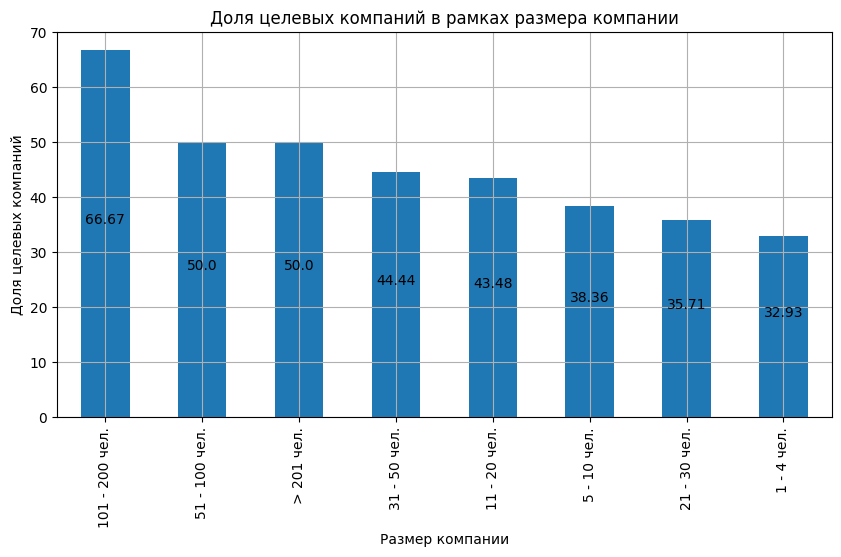

In [129]:
draw_bar(
    employer_count_interval_pivot[['percent']].sort_values(by='percent', ascending=False),
    'percent',
    'Доля целевых компаний в рамках размера компании',
    'Размер компании',
    'Доля целевых компаний',
    annotate=1
)


Если рассматривать размеры компаний из описательных данных, то можно сказать что доли компаний по каждой группе примерно равны как для целевых, так и нецелевых пользователей.
Больше всего целевых пользователей в размере "11-20 человек", если не учитывать малочисленные категории.

In [130]:
employer_count_interval_pivot = (
    companies_stat
    .query('payment_is_last == True')
    .pivot_table(index='employer_count_interval_calc', columns='company_is_active', values='company_id', aggfunc='count', fill_value=0)
)

employer_count_interval_pivot['percent'] = round(employer_count_interval_pivot[True]/(employer_count_interval_pivot[True] + employer_count_interval_pivot[False]) * 100, 2)
employer_count_interval_pivot.index = employer_count_interval_pivot.index.map(dictionary['employer_count_interval'])
display(employer_count_interval_pivot.sort_values(by='percent', ascending=False))



company_is_active,False,True,percent
employer_count_interval_calc,,,
21 - 30 чел.,1,2,66.67
11 - 20 чел.,13,15,53.57
5 - 10 чел.,115,79,40.72
1 - 4 чел.,333,148,30.77


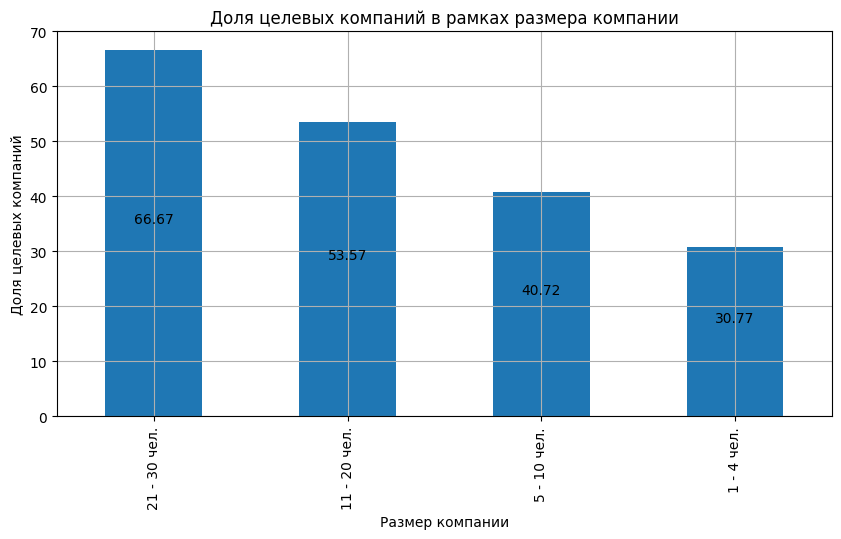

In [131]:
draw_bar(
    employer_count_interval_pivot[['percent']].sort_values(by='percent', ascending=False),
    'percent',
    'Доля целевых компаний в рамках размера компании',
    'Размер компании',
    'Доля целевых компаний',
    annotate=1
)


По данным из фактического количества сотрудников в компании видно, что доля размеров по группам отличается. Но в целом так же как и для первого случая, самая большая доля целевых пользователей у компаний с "11-20 человек", не учитывая группы, в которых меньше 10 компаний.

## Исследование активностей

In [132]:
print('Всего в файле с активностями `activities` {} записей.'.format(activities.shape[0]))
print('-'*50)
print('Уникальных компаний: {}.'.format(activities['company_id'].nunique()))
print('Уникальных месяцев: {}.'.format(activities['month'].nunique()))
print('-'*50)
print('Период активностей c `{}` по `{}`.' .format(activities['month'].min().date(), activities['month'].max().date()))

Всего в файле с активностями `activities` 6316 записей.
--------------------------------------------------
Уникальных компаний: 716.
Уникальных месяцев: 63.
--------------------------------------------------
Период активностей c `2019-01-01` по `2024-03-01`.


Промаркируем таблицу активностей номером группы тарифных планов в зависимости от ID компании и даты действия тарифного плана, согласно биллингу.

Строим срез данных из файла с биллингом: 
- выбираем только нужные нам поля;
- сортируем по ID компании и дате создания платежа;
- переформировываем индексы;
- после этого убираем пересечение дат с тарифными планами, корректируем "дату до", если появился новый платеж раньше.

In [133]:
company_tariff = (
    billing[['company_id', 'billing_tariff_type', 'create_date', 'until_date', 'company_is_active' ]]
    .sort_values(by=['company_id', 'create_date'])
    .reset_index(drop=True)
)

for i in company_tariff.index[:-1]:
    if company_tariff.loc[i, 'company_id'] == company_tariff.loc[i + 1, 'company_id']:
        company_tariff.at[i, 'until_date'] = pd.to_datetime(company_tariff.loc[i + 1, 'create_date']) - pd.Timedelta(days=1)


Делаем слияние полученной таблицы cross join по ID компании с таблицей активностей, а потом удаляем такие строки, где месяц не попадает в диапазон даты начала и даты окончания тарифного плана.

In [134]:
activities_with_tariff = pd.merge(activities, company_tariff, on='company_id') 
activities_with_tariff = activities_with_tariff[
                                (activities_with_tariff['month'] >= activities_with_tariff['create_date']) 
                                & 
                                (activities_with_tariff['month'] <= activities_with_tariff['until_date'])
]
activities_with_tariff

,company_id,month,billing,stocks,backups,projects,contractors,resource_orders,billing_tariff_type,create_date,until_date,company_is_active
0,1,2019-09-01,1,0,0,7,0,0,4,2019-07-23 15:48:05,2020-04-20 10:49:56,False
2,1,2019-12-01,1,0,0,2,1,0,4,2019-07-23 15:48:05,2020-04-20 10:49:56,False
4,1,2020-04-01,4,1,0,1,6,0,4,2019-07-23 15:48:05,2020-04-20 10:49:56,False
7,1,2020-07-01,1,7,3,5,0,0,4,2020-04-21 10:49:56,2021-07-25 23:59:59,False
8,1,2020-03-01,0,34,0,0,0,0,4,2019-07-23 15:48:05,2020-04-20 10:49:56,False
...,...,...,...,...,...,...,...,...,...,...,...,...
14081,9777,2024-02-01,0,0,0,1,1,5,2,2024-01-29 10:20:40,2025-03-29 00:00:00,True
14086,9815,2024-03-01,0,9,0,10,2,4,2,2024-02-27 10:45:26,2025-03-27 00:00:00,True
14088,9817,2024-02-01,0,5,0,5,0,0,1,2024-01-25 07:27:30,2025-03-01 00:00:00,True
14089,9817,2024-03-01,0,1,0,6,0,0,1,2024-01-25 07:27:30,2025-03-01 00:00:00,True


Получили дубликат таблицы `activities`, где каждая запись помечена конкретным тарифным планом, действующим для конкретной компании в конкретный месяц.

### Продолжительность активности

Посмотрим статистику продолжительности активностей в рамках одной компании, количество строк (месяцев) в файле `activities` по конкретной компании.

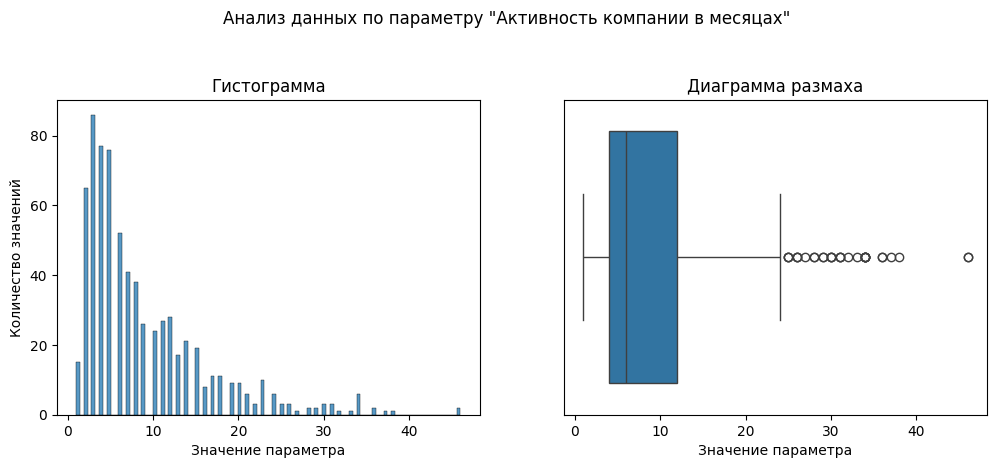

Всего значений: 716

Среднее арифметическое значение: 8.82
Медианное значение: 6.0
В среднем значения варьируются от 4.0 до 12.0
Минимальное значение 1.0
Максимальное значение 46.0


In [135]:
draw_hist_and_box(
    activities['company_id'].value_counts().reset_index(name='month_cnt'),
    'month_cnt', 
)

Анализируя данные о продолжительности активности компаний, можно отметить следующее:

- изучены данные по активности 716 компаний (что соответствует количеству компаний в файле компаний `companies`);
- средняя продолжительность активности составляет 8.82 месяца;
- медианное значение продолжительности активности — 6 месяцев, что указывает на то, что половина компаний имеет активность, не превышающую этот срок;
- большинство значений продолжительности активности колеблется в диапазоне от 4 до 12 месяцев, демонстрируя, что для значительного количества компаний характерна активность средней продолжительности;
- минимальная продолжительность активности, зарегистрированная в данных, составляет 1 месяц, что может отражать случаи краткосрочной или пробной активности;
- максимальная продолжительность активности достигает 46 месяцев, выделяя отдельные компании с длительным периодом непрерывной активности, что значительно превышает средние показатели.

Таким образом, данные подчеркивают разнообразие продолжительности активности компаний, отражая как краткосрочную, так и долгосрочную стратегии ведения бизнеса среди изученных клиентов.

### Суммарная статистика активностей по всем месяцам

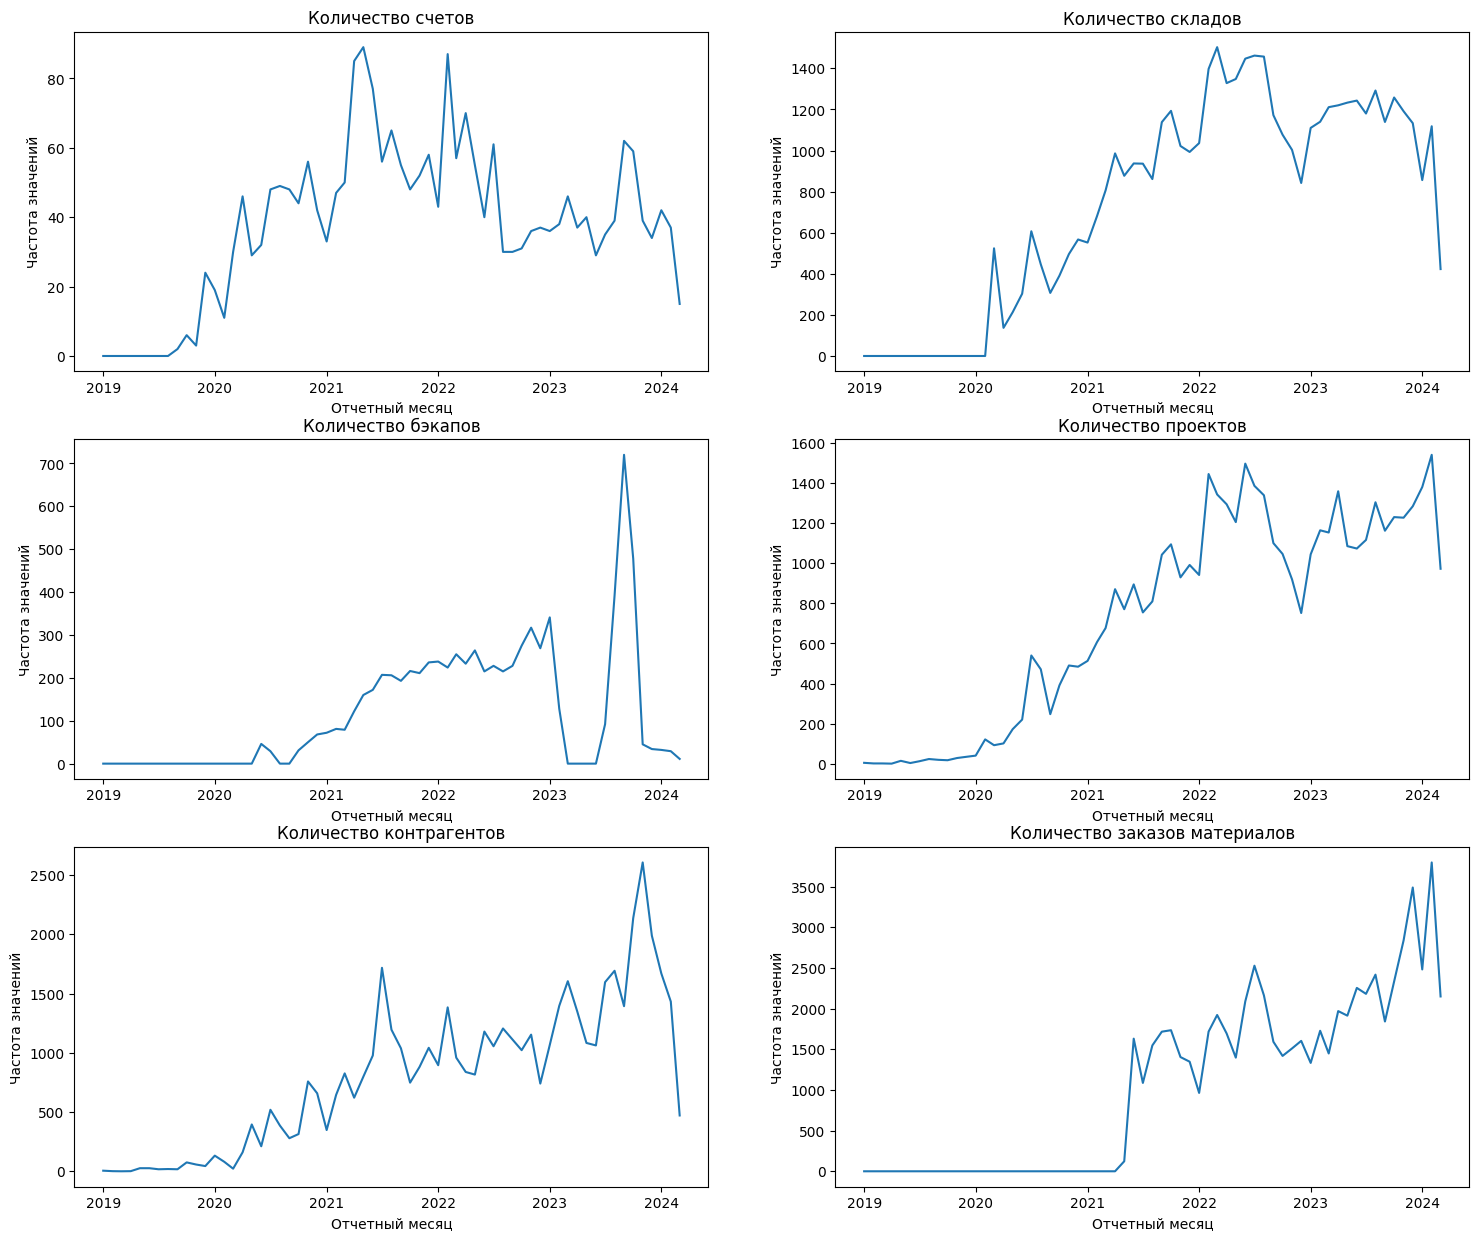

In [136]:
fields = ['billing', 'stocks', 'backups', 'projects', 'contractors', 'resource_orders']

activities_pivot = activities.pivot_table(index='month', values=fields, aggfunc='sum').reset_index()

draw_plot_all(activities_pivot, 'month', fields, 3, 2, '', '')

В целом, тренд активности компаний демонстрирует постепенный рост до конца 2022-2023 года, после чего наблюдается спад, что может указывать на изменения во внешней среде или в самих моделях ведения бизнеса.


Осенний период 2022 года выделяется небольшим падением активности, что, вероятно, связано с внешними экономическими факторами, такими как отток населения из страны и снижение активности в сфере строительства, что подчеркивает влияние макроэкономических условий на бизнес-процессы.


В контексте использования бэкап-системы, замечен резкий спад активности до нуля в начале 2023 года, который продолжался до середины года. Это могло быть вызвано техническими проблемами или ошибками в сборе данных. После этого периода наблюдается внезапное увеличение активности к концу 2024 года, за которым следует ещё одно значительное снижение, подчеркивая нестабильность в данном сегменте.


Отдельное внимание заслуживает критерий заказа материалов, который стал доступен начиная с первой половины 2021 года. Этот сервис сразу же нашел отклик среди компаний, демонстрируя высокую степень вовлеченности и положительную динамику использования, что свидетельствует о его актуальности и востребованности в бизнес-процессах.


Таким образом, общая картина активности компаний отражает как структурные изменения в экономике и отраслях, так и специфические внутренние и технические аспекты функционирования отдельных сервисов и инструментов, что в совокупности формирует сложную и многогранную динамику развития бизнес-активности.

### Активности по тарифным планам

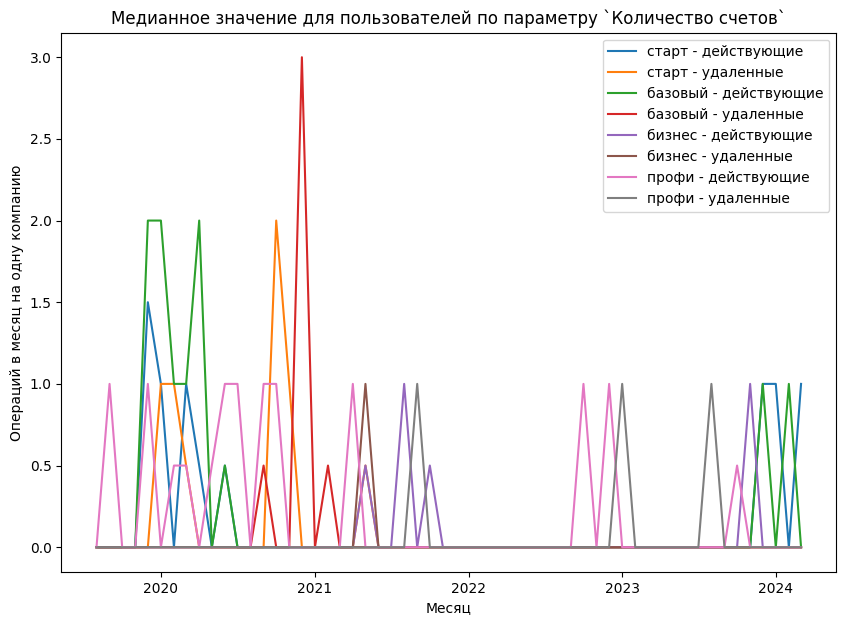

In [137]:
draw_activity(
    activities_with_tariff, 
    'billing',
)

Анализ активности пользователей сервиса по выставлению счетов в контексте различных тарифных планов выявил ряд ключевых особенностей:

- Общий уровень активности по выставлению счетов оказался низким по всем типам тарифных планов, что подтверждается значительным количеством нулевых значений в данных.
- Медианные показатели активности по группам тарифных планов демонстрируют сходство и варьируются в пределах от 0.5 до 3 счетов в месяц на компанию. 
- В ходе сравнительного анализа активности ушедших и оставшихся пользователей было выявлено, что пользователи на тарифах "старт" и "базовый", которые покинули сервис, демонстрировали несколько более высокую активность по сравнению с текущими пользователями. Однако среди тарифов "бизнес" и "профи" более активными оказались оставшиеся пользователи.
- Специфический период наблюдений с конца 2021 года по конец 2022 года, а также в начале 2023 года, характеризовался медианным значением количества счетов от компании в месяц, равным 0. 


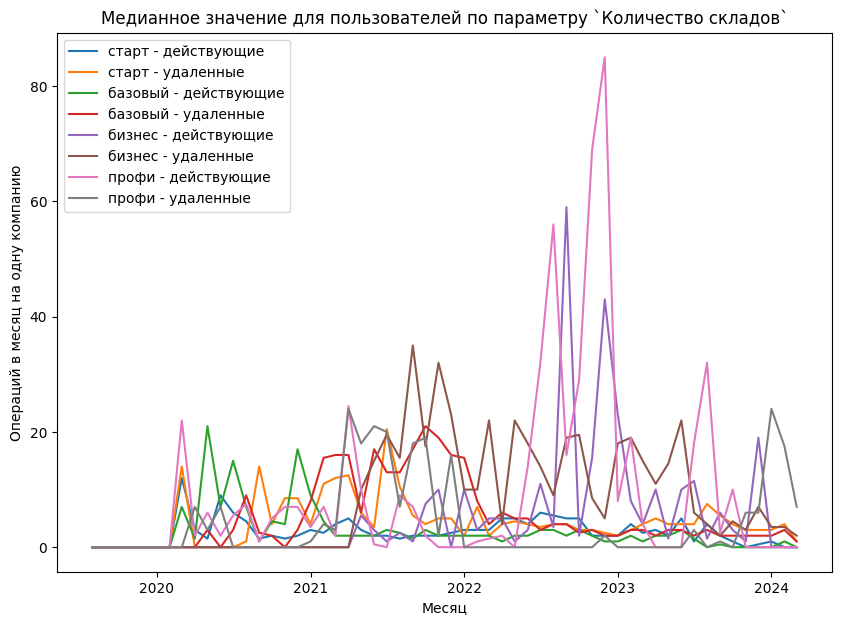

In [138]:
draw_activity(
    activities_with_tariff, 
    'stocks',
)

Анализ активности пользователей сервиса по количеству складов в контексте различных тарифных планов выявил ряд ключевых особенностей:

- Наблюдается сдержанная активность пользователей, подписанных на тарифные планы "старт" и "базовый". При этом анализ графиков показывает, что медианное значение активности ушедших пользователей незначительно превышает аналогичный показатель среди действующих пользователей данных тарифов.
- Высокая активность на продвинутых тарифах. Пользователи, использующие тарифные планы "бизнес" и "профи", демонстрируют значительно более высокую активность по сравнению с ушедшими. Это свидетельствует о том, что действующие абоненты этих тарифов находят больше возможностей для эффективного использования сервиса, в то время как компании, прекратившие пользование сервисом, не показывали высокой активности.
- Медианная активность пользователей варьируется от 0 до 80 операций в месяц. К концу 2022 года наблюдалась заметная тенденция к увеличению активности среди пользователей тарифов "бизнес" и "профи", причем средний показатель активности этих групп был более чем в три раза выше по сравнению с другими категориями пользователей.
- Зафиксировано падение уровня активности пользователей с начала 2023 года, что может свидетельствовать о наличии внешних или внутренних факторов, оказавших влияние на поведение и предпочтения пользователей сервиса в этот период.

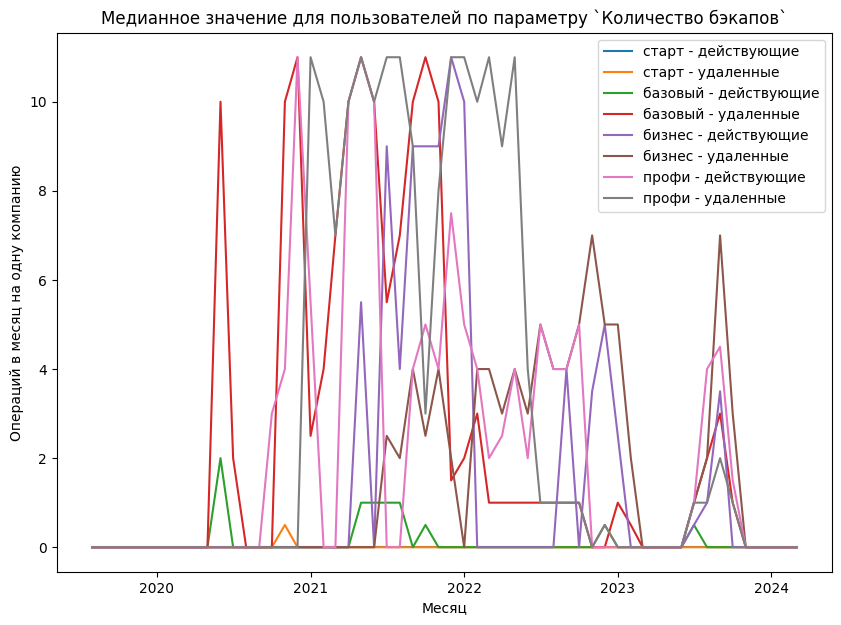

In [139]:
draw_activity(
    activities_with_tariff, 
    'backups',
)

Анализ активности пользователей сервиса по количеству бэкапов в контексте различных тарифных планов выявил ряд ключевых особенностей:

- Не было зафиксировано значимой активности пользователей, подписанных на тарифный план "старт". Это может быть обусловлено отсутствием доступа к функционалу резервного копирования в рамках данного тарифа.
- У пользователей, прекративших пользование сервисом, активность по созданию резервных копий на тарифе "базовый" превышала аналогичный показатель среди оставшихся пользователей более чем в четыре раза. Это указывает на наличие потребности в данной функции среди оттока клиентов.
- Медианная активность варьировалась от 0 до 11 бэкапов на пользователя в месяц, что демонстрирует разнообразие паттернов использования сервиса среди абонентов.
- До середины 2022 года пользователи на тарифе "бизнес" демонстрировали более высокую активность, однако после этого периода активнее стали пользователи, прекратившие пользование сервисом. Среди пользователей тарифа "профи" до середины 2022 года активнее были удаленные пользователи, затем активность сместилась в сторону действующих абонентов.
- Было отмечено падение активности до нулевых значений, что потенциально может быть связано с техническими неполадками сервиса или ошибками в сборе данных. Во второй половине 2023 года последовал резкий рост активности, особенно среди пользователей тарифов "бизнес" (удаленные и действующие) и "профи" (действующие), после чего активность вновь снизилась до медианных значений в районе нуля.

На основе проведенного анализа можно предположить, что в сервисе могут существовать определенные проблемы с функционалом резервного копирования, что сказывается на его использовании пользователями. 

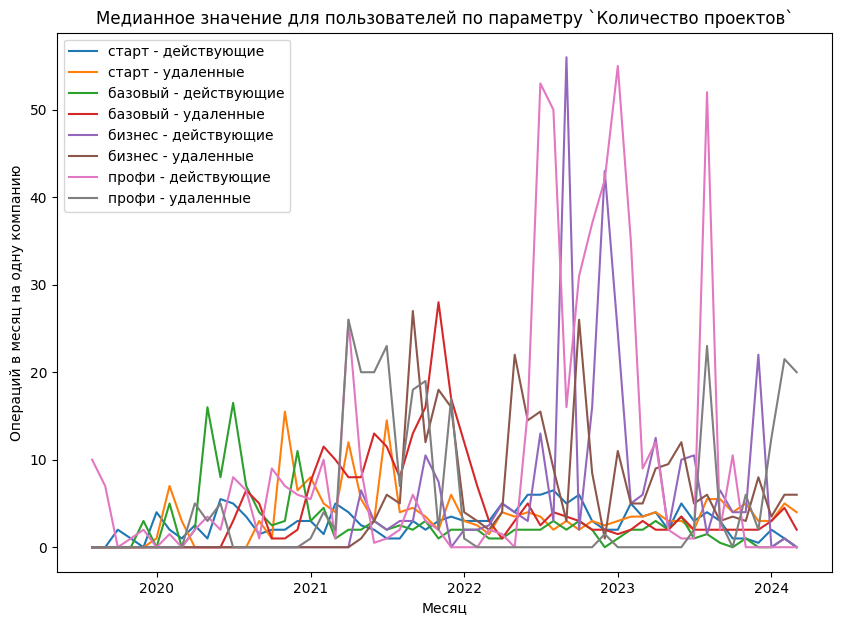

In [140]:
draw_activity(
    activities_with_tariff, 
    'projects',
)

Анализ активности пользователей сервиса по количеству проектов в контексте различных тарифных планов выявил ряд ключевых особенностей:

- До 2022 года преобладала активность ушедших пользователей с тарифным планом "старт", однако после этого периода наблюдается сравнение активности с действующими пользователями, причем показатели обеих групп становятся схожими и колеблются в пределах до 5 проектов в месяц.
- До 2022 года зафиксирована значительная активность среди обеих групп пользователей с тарифным планом "базовый", в то время как после 2022 года активность значительно снизилась до минимальных показателей.
- Среди действующих клиентов с тарифом "бизнес" наблюдается высокая активность, с незначительными колебаниями, включая небольшое снижение в середине 2023 года.
- Для пользоватей тарифа "профи" с середины 2022 до середины 2023 года была характерна наивысшая активность среди действующих компаний, превышающая показатели других групп более чем в два раза.
- Начиная с 2024 года, фиксируется общее снижение активности по всем категориям пользователей, что может указывать на изменения в рыночных условиях, влияние внешних факторов или изменение в стратегии использования сервиса пользователями.
- Медианные значения по количеству проектов в месяц варьируются в широком диапазоне от 0 до более чем 50, что отражает значительное разнообразие в уровне активности среди пользователей различных тарифных планов.


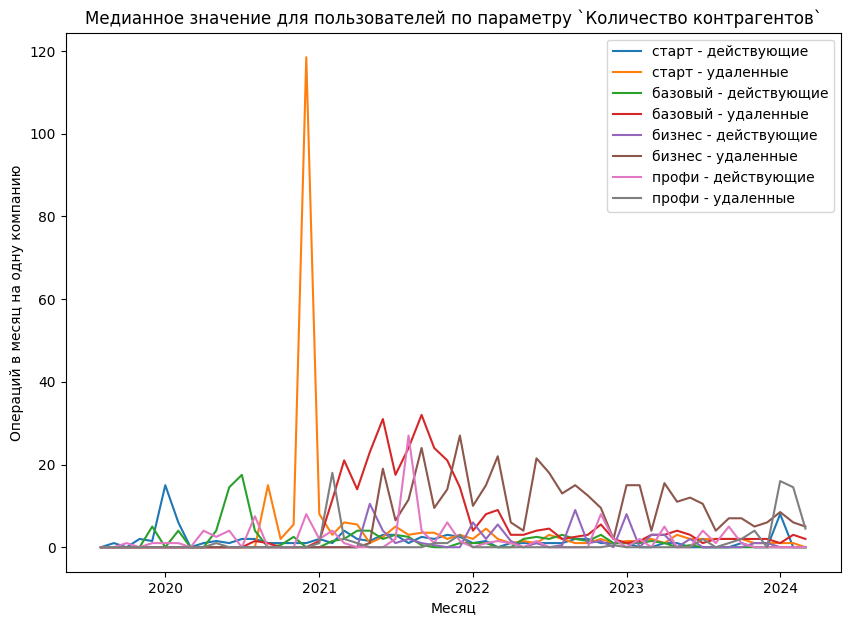

In [141]:
draw_activity(
    activities_with_tariff, 
    'contractors',
)

Анализ активности пользователей сервиса по количеству контрагентов в контексте различных тарифных планов выявил ряд ключевых особенностей:

- Медианная активность пользователей по большей части колеблется в диапазоне от 0 до 30 контрагентов на пользователя. Однако, замечен знаковый пик активности, достигший почти 120 контрагентов в конце 2020 года среди пользователей, прекративших использование тарифного плана "старт".
- На протяжении наблюдаемого периода высокую активность продемонстрировали пользователи с тарифным планом "базовый" (удаленные), "бизнес" (удаленные) и "профи" (действующие).
- Лидеры активности в начале 2024 года: "профи" (удаленные), "бизнес" (удаленные), "старт" (действующие).
- Самые низкие показатели активности были отмечены среди следующих групп пользователей: "базовый" и "старт" (удаленные), действующие пользователи тарифов "базовый", "профи" и "бизнес".


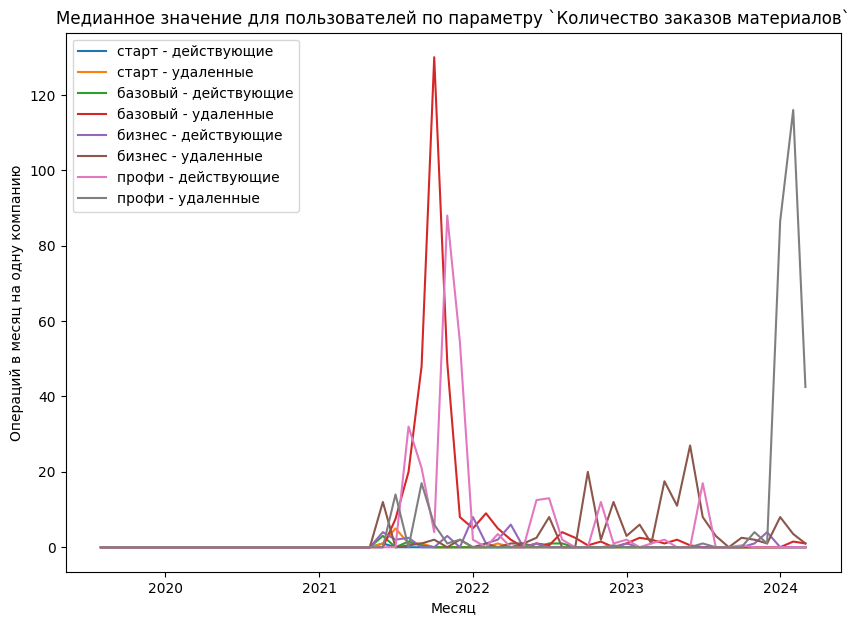

In [142]:
draw_activity(
    activities_with_tariff, 
    'resource_orders',
)

Анализ активности пользователей сервиса по количеству заказов материалов в контексте различных тарифных планов выявил ряд ключевых особенностей:

- До середины 2021 года фиксируется отсутствие активности пользователей, что позволяет предположить, что соответствующий функционал сервиса в указанный период не был введен в эксплуатацию или не пользовался спросом среди пользователей. 
- После середины 2021 года наблюдается существенный рост активности, особенно заметный среди пользователей на тарифных планах "базовый" (удаленные пользователи) и "профи" (действующие пользователи). Данный подъем активности указывает на успешную интеграцию и принятие новых функциональных возможностей сервиса целевыми группами пользователей.
- Во всем наблюдаемом периоде особенно выражена активность среди удаленных пользователей тарифного плана "бизнес", что свидетельствует о стабильном интересе данной категории к сервису.
- С конца 2023 по начало 2024 года зафиксирован резкий всплеск и последующее падение активности среди удаленных пользователей тарифа "профи", подчеркивающее динамичное изменение потребностей и интересов данной группы.
- Несмотря на отдельные пики активности, медианные значения за весь период колеблются от 0 до более чем 120, при этом в 2022 и 2023 годах максимальные медианные показатели не превышали отметку в 20, что отражает общую тенденцию к умеренному использованию сервиса большинством пользователей.



Обобщая проведенные анализы активности пользователей сервиса по различным параметрам — выставлению счетов, использованию складов, созданию резервных копий, выполнению проектов и заказам материалов в контексте тарифных планов, можно сделать следующие выводы:

- Наблюдается явная корреляция между некоторыми видами активности и статусом пользователя сервиса. В частности, ушедшие пользователи тарифных планов "старт" и "базовый" зачастую демонстрируют более высокую активность перед уходом, в то время как среди тарифов "бизнес" и "профи" активнее остаются действующие пользователи. 
- Наиболее значимыми индикаторами, которые могут служить предвестниками скорого ухода компании, являются резкие изменения в активности, такие как увеличение числа выставленных счетов или использование складских мощностей перед уходом. Особенно это заметно на начальных тарифах, где возможен недостаток необходимых функций или услуг.
- Компании на различных тарифных планах проявляют неоднородную активность, что, скорее всего, связано с разницей в доступных функциях и потребностях компаний в зависимости от их размера, сферы деятельности и бизнес-стратегии. Так, компании на более высоких тарифах демонстрируют большую активность, что может быть обусловлено более широким спектром предлагаемых сервиса услуг и большей зависимостью бизнес-процессов от предоставляемого функционала. Разнообразие в активности компаний на разных тарифах может быть связано как с различиями в предложении сервиса, так и с изменениями во внешней среде и внутренних потребностях компаний. Резкие пики и падения активности, особенно на фоне технических проблем или изменений в условиях использования сервиса, могут сигнализировать о критических точках, на которые следует обратить внимание при планировании стратегии удержания клиентов.


### Вывод

Анализ продолжительности активности компаний, основанный на данных **716 компаний**, выявил значительное разнообразие в их поведении и предпочтениях. **Средняя активность составила 8.82 месяца**, с медианным значением в 6 месяцев, указывая на то, что **большинство компаний демонстрируют среднесрочное взаимодействие с сервисом**. Минимальная и максимальная продолжительности активности — 1 и 46 месяцев соответственно — подчеркивают широкий спектр пользовательского поведения, от краткосрочного тестирования сервиса до длительного и стабильного использования.

Наблюдаемый **общий тренд активности демонстрирует рост до конца 2022-2023 года, за которым следует спад**. Это может отражать изменения во внешней среде или адаптацию бизнес-моделей компаний к новым условиям. Особое внимание заслуживает осенний период 2022 года с заметным снижением активности, возможно, из-за экономических факторов или оттока населения.

Анализ активности по ключевым параметрам — выставлению счетов, использованию складов, созданию бэкапов, выполнению проектов и заказу материалов — выявил следующие тенденции:

**Существует связь между видом активности и статусом пользователей**, особенно заметную на тарифных планах "старт" и "базовый", где ушедшие пользователи демонстрировали более высокую активность.
Изменения в активности, такие как увеличение числа счетов или использование складских мощностей, могут служить индикаторами предстоящего ухода компании, особенно на начальных тарифах.
Различные тарифные планы показали неоднородную активность, что, вероятно, связано с разными потребностями и доступными функциями для каждой категории пользователей. **Компании на более высоких тарифах проявляли большую активность, что может быть обусловлено более глубокой интеграцией сервиса в их бизнес-процессы**.
**Резкие пики и падения активности, особенно с начала 2023 года, указывают на потенциальные технические проблемы или изменения в предложении сервиса, требующие дополнительного внимания**.



## Метрика удовлетворенности. Retention Rate (удержание)

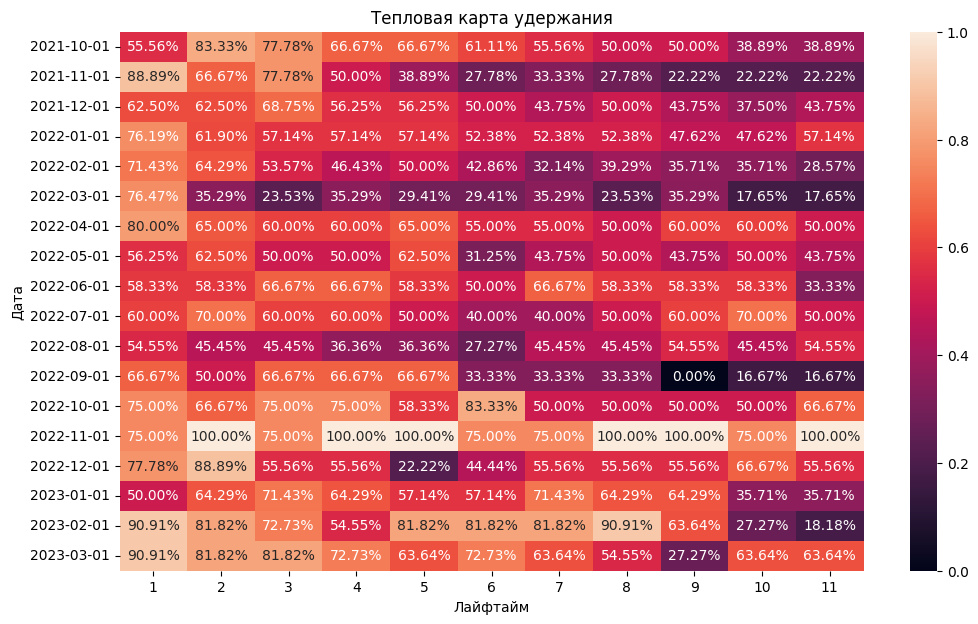

In [143]:
profiles = get_profiles(companies)

retention_rate = get_retention(profiles, activities, observation_date, horizon_months)

draw_heatmap(
    retention_rate.drop(columns = ['cohort_size',0]), 
    'Тепловая карта удержания', 
    'Лайфтайм', 
    'Дата',
)


In [144]:
last_suitable_acquisition_date = observation_date - relativedelta(months=horizon_months)
first_suitable_acquisition_date = observation_date - relativedelta(months=horizon_months*2.5)

profiles.query('@first_suitable_acquisition_date <= dt <= @last_suitable_acquisition_date').groupby('first_ts')['company_id'].nunique().reset_index(name='company_cnt')


,first_ts,company_cnt
0,2021-10-01,18
1,2021-11-01,18
2,2021-12-01,16
3,2022-01-01,21
4,2022-02-01,28
5,2022-03-01,17
6,2022-04-01,20
7,2022-05-01,16
8,2022-06-01,12
9,2022-07-01,10


**Вывод**

Анализ удержания пользователей показал высокую эффективность привлечения в феврале и марте 2023 года, особенно заметную в первый месяц после регистрации. На второй месяц наибольшее удержание наблюдалось среди компаний, зарегистрированных в ноябре 2022 года, что подчеркивает их значимость в долгосрочной перспективе. В частности, компании, привлеченные в ноябре 2022 года, демонстрировали максимальное удержание на протяжении всего года, хотя их когорта была относительно малочисленна. Также высокие показатели удержания показали пользователи, зарегистрированные в апреле, октябре и декабре 2022 года, что может указывать на успешность рекламных кампаний в эти периоды. Однако, общая малочисленность когорт делает сложным более детальный анализ эффективности удержания.

Удержание пользователей рассчитывалось по активности в приложении.

## RF - сегментации клиентской базы

RFM — это метод, используемый для анализа потребительской ценности.

Он группирует клиентов на основе истории их транзакций:
- Recency/Давность — как давно клиент совершил покупку;
- Frequency/Частота — как часто они совершают покупки;
- Monetary Value/Денежная ценность — сколько они тратят;

В нашем случае выберем в качестве:
- Recency - разницу в днях между текущей датой и датой, до которой действует последний платеж компании (он может быть отрицательной, если текущая дата позднее);
- Frequency — количество дней, оплаченных компанией (считаем только те платежи, которые были погашены);
- Monetary Value — одна из групп тарифных планов: старт, базовый, бизнес и профи (разные тарифные группы приносят разный доход), но отображать мы будем только первые два критерия.

**RF-анализ**. Анализ по давности и частоте покупок. Показывает, как часто клиенты совершают покупки за анализируемый период. Позволяет выявить клиентов, которые недавно что-то купили и сотрудничают с компанией постоянно.


In [145]:
rfm = (
    billing
    .sort_values(by='payed_until')
    .groupby('company_id')
    .agg(
        {
            'until_date': lambda x: (x.max() - start_date ).days, 
            'filtered_payment_life': 'sum',
            'billing_tariff_type' :  'last',
        }
    )
    .rename(
        columns={
            'until_date': 'r', 
            'filtered_payment_life': 'f',
            'billing_tariff_type' : 'm'
        }
    )
)


In [146]:
rfm_seg = rfm[['r', 'f']].quantile(q=[0.33, 0.66]).to_dict()

In [147]:
rfm['r_seg'] = rfm['r'].apply(to_seg, args=('r', rfm_seg, ))
rfm['f_seg'] = rfm['f'].apply(to_seg, args=('f', rfm_seg, ))
rfm['m_seg'] = rfm['m']
rfm['rfm_seg'] = rfm['r_seg'].map(str) + rfm['f_seg'].map(str) + rfm['m_seg'].map(str) 



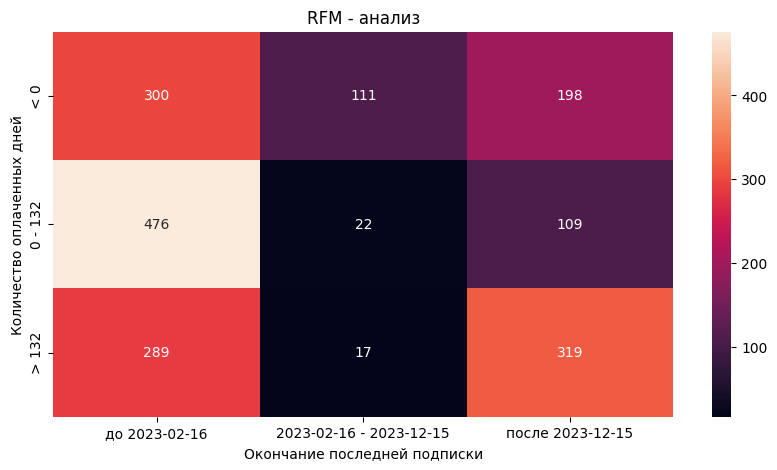

In [148]:
# Размер графика
plt.figure(figsize = (10, 5))


x1 = (start_date + timedelta(days=int(rfm_seg['r'][0.33]))).date()
x2 = (start_date + timedelta(days=int(rfm_seg['r'][0.66]))).date()

y1 = int(rfm_seg['f'][0.33])
y2 = int(rfm_seg['f'][0.66])

# Простроение графика
sns.heatmap(
        rfm.pivot_table(index='r_seg', columns='f_seg', values='r', aggfunc='count'), 
        annot = True,  
        fmt = 'd',
        xticklabels=[
                'до {0}'.format(x1), 
                '{0} - {1}'.format(x1,x2), 
                'после {}'.format(x2)
        ],
        yticklabels=[
                '< {0}'.format(y1), 
                '{0} - {1}'.format(y1,y2), 
                '> {}'.format(y2)
        ]
)

# Оформление графика
plt.title('RFM - анализ')  
plt.xlabel('Окончание последней подписки') 
plt.ylabel('Количество оплаченных дней') 

# Вывод графика
plt.show()  



In [149]:
company_2_1 = (rfm.query('r_seg == 2 and f_seg == 1').reset_index())['company_id'].unique()
billing.query('company_id in @company_2_1 and is_payed == False').groupby('company_id').filter(lambda x: len(x) == 1)['billing_tariff_id'].value_counts()


billing_tariff_id
2     252
7     150
9      48
10     22
4       2
3       1
11      1
Name: count, dtype: int64

**Вывод**

- Ключевым сегментом являются компании из нижнего правого квадранта, отличающиеся продлением подписки до 15 декабря 2023 года и наличием более 132 оплаченных дней использования сервиса. Этот сегмент демонстрирует высокую лояльность и денежную ценность, особенно те, кто выбирает высшие тарифные планы.
- Самая массовая категория пользователей включает тех, чья подписка истекла до 16 февраля 2023 года, с общим количеством оплаченных дней до 117. Более детальный анализ показал, что всем этим компаниям был выставлен 1 платеж, и он не был оплачен.
- Группы в верхней строке показывают отсутствие оплаты по всем платежам, данные клиенты не интересны бизнесу.
- Рекомендуется активно работать с группами из последнего столбца (2 и 3 ряд), это такие компании, у которых истек срок сервиса в конце прошлого года. Рекомендуется активно работать с этими группами, с фокусом на стимулирование продления подписок и оплаты. Персонализированные предложения, бонусы за продление и акцент на высокой ценности этих клиентов для нашего сервиса помогут укрепить отношения и стимулировать дальнейшее взаимодействие.

## Общий вывод

### Описание

Gectaro – облачный сервис для автоматизации управления строительством и ремонтом.

Компания продает софт с платной подпиской в сегменте B2B (наиболее частый срок подписки 12-24 месяца), предназначенный для управления процессами в сфере строительства и ремонта.

Основная проблема – это уход из сервиса большого количества подписчиков и не продление подписки.

### Задачи

- провести исследовательский анализ данных;
- сформулировать и проверить гипотезы, основываясь на имеющихся признаках;
- формулирование выводов по полученным результатам, подготовка презентации.

### Описание данных

**Файл активностей** `activities.csv`:

- `Company_id` - идентификатор компании;
- `Month` - отчетный месяц;
- `Company-month-billing` - количество счетов, выставленных в приложении, компанией за месяц;
- `Company-month-stocks` - месячное количество складов (аренда, заказы и т.д.), используемых компанией;
- `Company-month-backups` - месячное количество бэкапов компании;
- `Company-month-projects` - месячное количество проектов компании;
- `Company-month-contractors` - месячное количество контрагентов компании;
- `Company-month-resource_orders` - месячное количество заказов материалов компании.
 
**Файл платежей** `billing.csv`:
- `Unnamed:0` - индекс;
- `User_id` - идентификатор пользователя;
- `Company_id` - идентификатор компании пользователя;
- `Billing_tariff_id` - тарифный план;
- `Payed_until` - дата, до которой подписка компании действует;
- `Is_payed` - статус оплаты;
- `Created_at` - дата создания;
- `Updated_at` - дата обновления;
- `Billing_tariff_price_id` - id стоимости тарифа;
- `Comment` - комментарии;
- `Pay_date` - дата платежа.
 
**Файл компаний** `companies.csv`:
- `Id` - id компании; 
- `Working_direction` - сфера деятельности;
- `Employer_count_interval` - id количества сотрудников;
- `Created_at` - дата создания компании в системе;
- `Updated_at` - дата обновления информации о компании;
- `Billing_tariff_id` - id тарифа;
- `Billing_is_over` - истекла ли оплата.
 
**Файл сотрудников** `people.csv`:
- `Id` - индекс; 
- `Company_id` - id компании; 
- `User_id` - id пользователя; 
- `Role_id` - id роли (должности); 
- `Created_at` - дата создания пользователя; 
- `Updated_at` - дата обновления информации о пользователе; 
- `Is_deleted` - удален ли пользователь; 
- `Deleted_at` - дата удаления.

### Предобработка данных

В ходе предобработке данных:
- переименовали названия некоторых столбцов в датасетах;
- удалили лишние столбцы;
- разобрались с пропущенными значениями, заменили их на значения по умолчанию;
- преобразовали тип данных для некоторых столбцов, согласно описанию данных;
- выявили явные и неявные дубликаты, удалили их;
- добавили столбцы с датой во все датасеты в привычном формате;
- переформировали индексы во всех датасетах.

### Исследовательский анализ

#### Портрет компании-пользователя

- Уникальных компаний: 716.
- Уникальных размеров компании: 8.
- Уникальных тарифных планов: 13.
- Около 26% компаний работают в сфере строительства; примерно 5% занимаются вопросами ремонта; 63% компаний не указали свою специализацию. Данные в этом поле не имеют стандартизированного вида.
- Почти 70% компаний насчитывают от 1 до 4 сотрудников; 30% компании с количеством сотрудников от 5 до 10 человек; доля организаций с 11 до 20 работниками - 4%. Эта информация подчеркивает склонность к малому и среднему бизнесу среди участников исследования.
- Самый популярный тарифный план «2-базовый" почти у 45% компаний; далее тариф «7-старт" - 37% компаний; «9-бизнес" и «4-старт" с долями 6,42% и 5,03% соответственно; тариф «3-профи" - 1,54% компаний.
- У двух третьих компаний истекла оплата.
- Самый высокий процент неоплаты на тарифных планах "3-профи" и "11-старт" - 100% неоплата. Высокий процент неоплаты у тарифного плана "4-старт" - 97%, "7-старт" - 73%, "2-базовый" - 64%. По тарифам "19-старт", "20-бизнес" и "21-профи" оплата всегда была, но таких компаний очень мало.

Стоит обратить внимание:
- У 102 компаний количество пользователей в системе больше, чем заявленный размер компании.
- В таблице с пользователями очень много сотрудников с user_id=0. 
- Так же есть удаленные пользователи, но дата их удаления отсутствует.
- Наблюдается огромный всплеск активности при изменении данных по компаниям 6 декабря 2022 года. 

#### Целевые пользователи

Целевой пользователь - компания, у которой в таблице платежей есть платеж с датой продления сервиса позже, чем дата текущего анализа, независимо от того, оплатила компания его или нет. 

Процент компаний с одним платежом в таблице биллинга 86.31% (1589 компаний). Процент компаний только с одним платежом, который не был оплачен 57.69% (1062 компаний) .

Всего в таблице с платежами 3479 записей. Уникальных компаний: 1841, в таблице компани активностей гораздо меньше. На это стоит обратить внимание разработчикам. Уникальных тарифных планов: 13. Уникальных ценовых тарифов: 47.

В среднем подписка по одному платежу варьируются от полугода до полутора лет (для целевых пользователей от 1 до 2 лет).

Неактивные компании в среднем сразу оплачивали свой платеж, при этом из исследования выпало огромное количество платежей, которые так и не были оплачены. Целевые компании оплачивают сервис в течении недели.

Количество платежей для целевых и нецелевых пользователей в медианном значении равно одному, есть аномалии, компании у которых было до 17 платежей.

Согласно биллингу только 48% всех платежей были оплачены пользователями.

#### Влияние тарифного плана на уход компании

Существует статистически значимая зависимость между тарифным планом и уходом компании.

В обеих группах популярностью пользуются тарифные планы "2-базовый" и "7-старт", в группе с ушедшими эти доли чуть больше. В тоже время для целевых пользователей более высокая доля тарифного плана "9-бизнес". 

Для целевых пользователей характерно наличие тарифных планов "19-старт", "20-бизнес" и "21-профи", среди ушедших пользователей таких тарифных планов нет.

В группе с целевыми пользователями тариф "бизнес" используется чаще, чем для ушедших компаний.

Доля целевых пользователей на тарифном плане "9-бизнес" самая высокая среди всех тарифных планов 34% (исключая непопулярные тарифы).

Анализ структуры тарифных планов и их стоимости выявил интересную закономерность: в большинстве случаев каждая комбинация ID тарифа и ID стоимости является уникальной в пределах одного тарифного плана. Это подчеркивает структурированность и организованность тарифной политики. Однако были обнаружены исключения, которые придают системе тарификации дополнительную гибкость.

В частности, в рамках тарифной группы "старт", ID стоимости 16 объединяет в себе не только тариф "4-старт", но и "19-старт", демонстрируя перекрестную применимость стоимости между различными тарифными планами внутри одной группы. Аналогичная ситуация наблюдается и в тарифной группе "профи", где ID стоимости 41 связывает тарифы "13-профи" и "21-профи". Такие пересечения могут свидетельствовать о выделение нового тарифного плана из тарифной группы, например, для "старт" эта гипотеза подтвержается (тарифные планы "4-старт" и "19-старт" используются в разное время). Что же касается тарифных планов "13-профи" и "21-профи", то тут необходимо уточнение у заказчика).

#### Влияние размера на уход компании

Есть несоответствие размеров компании; для 102 из 716 пользователей фактический размер выше, чем заявленный.

Если анализировать заявленный параметр, то нет достаточных оснований для подтверждения зависимости ухода от размера компании.

Если анализировать фактическое значение параметра, то можно подтвердить наличие статистически значимой зависимости между переменными (результаты необходимо уточнить у заказчика).

Если рассматривать размеры компаний из описательных данных, то можно сказать что доли компаний по каждой группе примерно равны как для целевых, так и нецелевых пользователей. Больше всего целевых пользователей в размере "11-20 человек", если не учитывать малочисленные категории.

По данным из фактического количества сотрудников в компании видно, что доля размеров по группам отличается. Но в целом так же как и для первого случая, самая большая доля целевых пользователей у компаний с "11-20 человек", не учитывая группы, в которых меньше 10 компаний.

#### Исследование активностей компаний

Существует связь между видом активности и статусом пользователей, особенно заметную на тарифных планах "старт" и "базовый", где ушедшие пользователи демонстрировали более высокую активность.

Изменения в активности, такие как увеличение числа счетов или использование складских мощностей, могут служить индикаторами предстоящего ухода компании, особенно на начальных тарифах.

Различные тарифные планы показали неоднородную активность, что, вероятно, связано с разными потребностями и доступными функциями для каждой категории пользователей. 

Компании на более высоких тарифах проявляли большую активность, что может быть обусловлено более глубокой интеграцией сервиса в их бизнес-процессы.

Резкие пики и падения активности, особенно с начала 2023 года, указывают на потенциальные технические проблемы или изменения в предложении сервиса, требующие дополнительного внимания.

#### Удержание компаний

Высокая эффективность привлечения в феврале и марте 2023 года, особенно заметная в первый месяц после регистрации.  

На второй месяц наибольшее удержание наблюдалось среди компаний, зарегистрированных в ноябре 2022 года. 

Компании, привлеченные в ноябре 2022 года, демонстрировали максимальное удержание на протяжении всего года, хотя их когорта была очень малочисленна (всего 4 компании). 

Высокие показатели удержания показали пользователи, зарегистрированные апреле, октябре и декабре 2022 года, что может указывать на успешность рекламных кампаний в эти периоды.

#### RF - анализ

Анализ по давности и частоте покупок. Показывает, как часто клиенты совершают покупки за анализируемый период. Позволяет выявить клиентов, которые недавно что-то купили и сотрудничают с компанией постоянно.

Ключевым сегментом являются компании из нижнего правого квадранта, отличающиеся продлением подписки до 15 декабря 2023 года и наличием более 132 оплаченных дней использования сервиса. Этот сегмент демонстрирует высокую лояльность и денежную ценность, особенно те, кто выбирает высшие тарифные планы.

Самая массовая категория пользователей включает тех, чья подписка истекла до 16 февраля 2023 года, с общим количеством оплаченных дней до 117. Более детальный анализ показал, что всем этим компаниям был выставлен 1 платеж, и он не был оплачен.

Группы в верхней строке показывают отсутствие оплаты по всем платежам, данные клиенты не интересны бизнесу.

Рекомендуется активно работать с группами из последнего столбца (2 и 3 ряд), это такие компании, у которых истек срок сервиса в конце прошлого года. Рекомендуется активно работать с этими группами, с фокусом на стимулирование продления подписок и оплаты. Персонализированные предложения, бонусы за продление и акцент на высокой ценности этих клиентов для нашего сервиса помогут укрепить отношения и стимулировать дальнейшее взаимодействие.


### Общий вывод

На основе проведенного анализа данных сервиса можно сделать следующие ключевые выводы для презентации:

- Профиль типичного пользователя: Сервис чаще всего выбирают представители малого и среднего бизнеса, насчитывающие от 1 до 10 сотрудников, причем сфера их деятельности зачастую остается неуказанной. Предпочтительные тарифные планы — «базовый» и «стартовый» (по умолчанию).
- Длительность и своевременность оплаты: В среднем счета выставляются на период от одного до двух лет, с оплатой, как правило, в течение одной недели. При этом 57% всех платежей остаются не оплаченными.
- Повторное использование сервиса: Большинство компаний склонны к однократной оплате, что указывает на нежелание продлевать сервис после начального периода использования.
- Переход на продвинутые тарифы: Пользователи, нацеленные на долгосрочное взаимодействие и более активное использование сервиса, обычно подключают продвинутые тарифные планы, такие как «бизнес» и «профи».
- Рекомендации по удержанию: Целесообразно сосредоточить внимание на компаниях с истекающими подписками к концу 2023 года и предложить им привлекательные условия для удержания.
- Разногласия по размеру компаний: Существуют расхождения между заявленным и фактическим размером компаний, что требует более внимательного анализа и корректировки в системе биллинга.
- Динамика активности: На графиках видны всплески интереса пользователей к новым услугам в момент их запуска. Однако также фиксируются падения активности до нуля, что может сигнализировать о технических сбоях сервиса (например, при использовании бэкапов). Последующие резкие взлеты активности указывают на восстановление работы сервиса и возвращение пользователей.
- Влияние выбора тарифа на уход пользователя: Выбор тарифного плана имеет тесную связь с решением пользователя остаться или уйти, что подтверждает важность соответствия предложений сервиса потребностям клиентов. Клиенты менее охотно уходят с продвинутых тарифных планов.
- Влияние размера компании: Размер компании не является определяющим фактором ухода пользователя, однако некорректные данные о размере компании могут создавать искажения в данных анализа и стратегию удержания клиентов.
- 
Эти выводы позволят предпринять целенаправленные действия для оптимизации предложений, повышения удовлетворенности клиентов и укрепления позиций сервиса на рынке.